In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

import sklearn
from sklearn.feature_selection import VarianceThreshold


from imblearn.over_sampling import SMOTE
from collections import Counter

from scipy.stats import kendalltau

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import files
json = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#load the dataset from the kaggle : https://www.kaggle.com/c/santander-customer-satisfaction/data
!mkdir kaggle # create kaggle directory

!cp kaggle.json ~/.kaggle/ # copy the kggle.json into kaggle directory
!chmod 600 ~/.kaggle/kaggle.json # changing the operation
!kaggle competitions download -c santander-customer-satisfaction # download the dataset by using the kaggle api

mkdir: cannot create directory ‘kaggle’: File exists
100% 4.02M/4.02M [00:00<00:00, 19.9MB/s]

100% 4.05M/4.05M [00:00<00:00, 11.5MB/s]

  0% 0.00/612k [00:00<?, ?B/s]
100% 612k/612k [00:00<00:00, 61.2MB/s]


In [ ]:
# unzip the files
!unzip train.csv
!unzip test.csv

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    #print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    B =(C/C.sum(axis=0))
    
    labels = [0,1] #,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [ ]:
def dataset_analysis(df):
  """
   this function takes dataframe as input and gives some description and details are generated.
  """
  print("This dataset having {0} rows and {1} columns.".format(df.shape[0],df.shape[1]))
  int_cols=[]
  float_cols = []
  obj_cols=[]
  for i in df.columns[:]:
    if df[i].dtype == "int":
      int_cols.append(i)
    elif df[i].dtype == "float":
        float_cols.append(i)
    else:
        obj_cols.append(i)
    
  print("dataset have {0} integer type & {1} float type & {2} object type".format(len(int_cols),len(float_cols),len(obj_cols)))
  print("-"*50)
  print(df.info())
  print("-"*50)
  #print(df.head(3))
  return df.head(3)
  #print(df.describe())

In [ ]:
def missingdata_pts(df):
  """
     this function takes dataframe as input and check there is any missing /Nan values are existed in that dataframe.
  """
  # check the missing values in the given dataset.
  print("the missing values in the given dataset is {0}.".format(df.isna().sum().sum()))

In [ ]:
# removing the constant features
def constant_features(df):
  """
    Constant Feature: Same value in all the records. 
    it takes dataframe as input and remove the constant features because those kind of features are not useful for classification.
  """
  constant_columns = []
  for i in df.columns[:]:
    if df[i].nunique() == 1:
      constant_columns.append(i)
  print("{0} of constant features in the given dataframe".format(len(constant_columns)))
  return constant_columns

In [ ]:
def quasiconstant_features(df):
  """
  Quasi Constant Feature: One of the values is dominant 99.9%.
  """
  import sklearn
  from sklearn.feature_selection import VarianceThreshold
  a = VarianceThreshold(threshold=0.01)
  a.fit(df)
  quasi_columns = df.columns[:][~a.get_support()]
  print("The no of quasiconstant features in the given dataframe:{}".format(len(quasi_columns)))
  return quasi_columns

In [ ]:
def duplicate_feature_removal(df):
  """
     this function takes dataframe as input and remove the duplicated valued features.
  """
  # drop the duplicated features in terms of names and values.
  a=df.shape[1]
  #A.T.drop_duplicates(keep="last").T
  df = df.T.drop_duplicates(keep="first").T
  c= df.shape[1]
  print("The no of duplicated columns are removed having same values : ",(a-c))
  return df

In [ ]:
dataframe_train = pd.read_csv("train.csv")
dataset_analysis(dataframe_train)

This dataset having 76020 rows and 371 columns.
dataset have 260 integer type & 111 float type & 0 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB
None
--------------------------------------------------


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

In [ ]:
# remove that outlier point.
dataframe_train = dataframe_train[dataframe_train["delta_imp_reemb_var33_1y3"]==0]

#
# all of the values are zero except four values . 
dataframe_train = dataframe_train[dataframe_train["delta_imp_trasp_var17_out_1y3"]==0]

# remove those points 
dataframe_train = dataframe_train[dataframe_train["imp_reemb_var17_hace3"]==0]

# remove those points 
dataframe_train = dataframe_train[dataframe_train["saldo_medio_var29_hace3"]==0] 


In [ ]:
cons = constant_features(dataframe_train)
dataframe_train = dataframe_train.drop(cons,axis=1)
print("shape of the tarin data after removing the constant features :",dataframe_train.shape)

quasicons = quasiconstant_features(dataframe_train)
dataframe_train = dataframe_train.drop(quasicons,axis=1)
print("the shape of the dataframe after removing the quasiconstant features :",dataframe_train.shape)

dataframe_train = duplicate_feature_removal(dataframe_train)
print("the shape of the dataframe after removing the duplicate features : ",dataframe_train.shape)

45 of constant features in the given dataframe
shape of the tarin data after removing the constant features : (76013, 326)
The no of quasiconstant features in the given dataframe:60
the shape of the dataframe after removing the quasiconstant features : (76013, 266)
The no of duplicated columns are removed having same values :  15
the shape of the dataframe after removing the duplicate features :  (76013, 251)


In [15]:
dataframe_train.head(3)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var41_0,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_var7_recib_ult1,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var39_vig_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_comer_ult1,num_op_var41_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto

# base

In [ ]:
dataset_analysis(dataframe_train)

This dataset having 76013 rows and 251 columns.
dataset have 0 integer type & 251 float type & 0 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 76013 entries, 0 to 76019
Columns: 251 entries, ID to TARGET
dtypes: float64(251)
memory usage: 148.6 MB
None
--------------------------------------------------


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var41_0,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_var7_recib_ult1,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var39_vig_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_comer_ult1,num_op_var41_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto

In [ ]:
X = dataframe_train.drop(["ID","TARGET"],axis=1)
Y = dataframe_train["TARGET"]

In [ ]:
X.shape

(76013, 249)

In [ ]:
from sklearn.model_selection import train_test_split
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(X,Y,stratify=Y,test_size=0.20)

print('Number of data points in train data:', X_train.shape)
print('Number of data points in test data:', X_test.shape)

Number of data points in train data: (60810, 249)
Number of data points in test data: (15203, 249)


In [ ]:
from sklearn.model_selection import train_test_split
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(X,Y,stratify=Y,test_size=0.20)

print('Number of data points in train data:', X_train.shape)
print('Number of data points in test data:', X_test.shape)

Number of data points in train data: (60810, 249)
Number of data points in test data: (15203, 249)


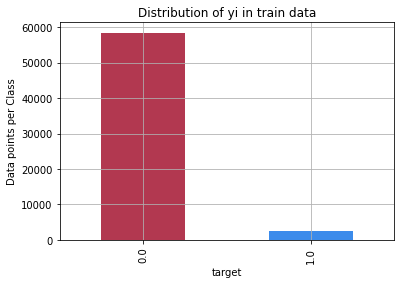

Number of data points in class 1 : 58404 ( 96.043 %)
Number of data points in class 2 : 2406 ( 3.957 %)
--------------------------------------------------------------------------------


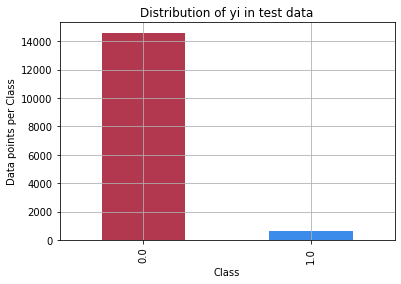

Number of data points in class 1 : 14601 ( 96.04 %)
Number of data points in class 2 : 602 ( 3.96 %)


In [ ]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts()
test_class_distribution = y_test.value_counts()

my_colors = ['#b23850', '#3b8beb'] #, '#e7e3d4', '#c4dbf6', '#8590aa', '#0d19a3', '#15db95', '#080f5b', '#f79e02']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('target')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = ['#b23850', '#3b8beb'] # , '#e7e3d4', '#c4dbf6', '#8590aa', '#0d19a3', '#15db95', '#080f5b', '#f79e02']
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')


In [ ]:
from sklearn.metrics import roc_auc_score

## logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# logistic regression refer : https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35
# solvers in logistic regression : https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
grid_params1 = {"penalty":["elasticnet","l1","l2"],"C":[10**x for x in range(-5,4)]} # ,"elasticnet"
logistic_clf1 = RandomizedSearchCV(lg,grid_params1,cv=5,return_train_score=True,scoring="roc_auc",n_jobs=-1)
logistic_clf1.fit(X_train,y_train)

print("classification best parameters : ",logistic_clf1.best_params_)
print("Best score : ",logistic_clf1.best_score_)
print("="*50)
print("Train AUC scores")
print(logistic_clf1.cv_results_["mean_train_score"])
print("CV AUC scores")
print(logistic_clf1.cv_results_["mean_test_score"])

classification best parameters :  {'penalty': 'l2', 'C': 100}
Best score :  0.6059748824988096
Train AUC scores
[0.6052835         nan        nan        nan 0.60617336 0.60504065
        nan        nan        nan        nan]
CV AUC scores
[0.60483666        nan        nan        nan 0.60597488 0.60458773
        nan        nan        nan        nan]


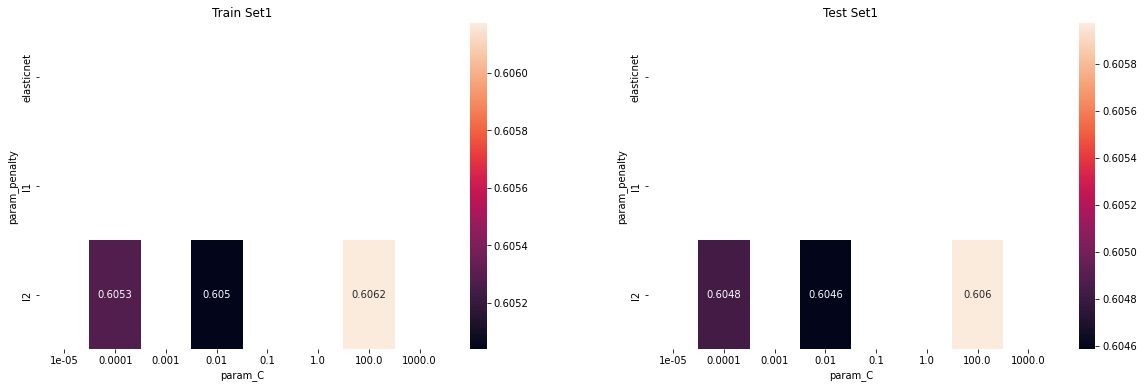

In [ ]:
max_scores1 = pd.DataFrame(logistic_clf1.cv_results_).groupby(['param_penalty', 'param_C']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set1')
ax[1].set_title('Test Set1')

plt.show()

In [ ]:
logistic_clf1.best_params_

{'C': 100, 'penalty': 'l2'}

{'penalty': 'l2', 'C': 100}
-------------------------------------------------- Confusion matrix --------------------------------------------------


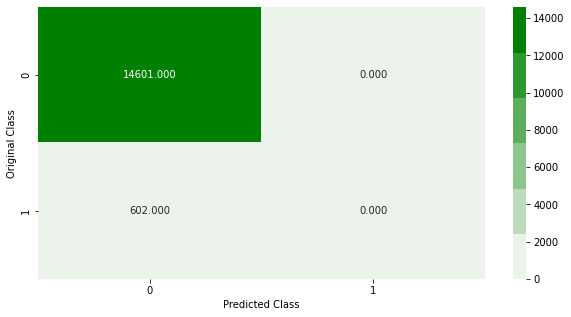

-------------------------------------------------- Precision matrix --------------------------------------------------


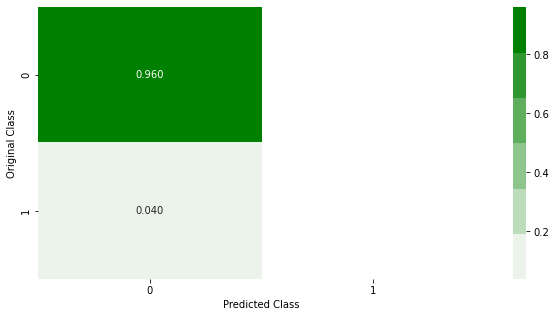

Sum of columns in precision matrix [ 1. nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


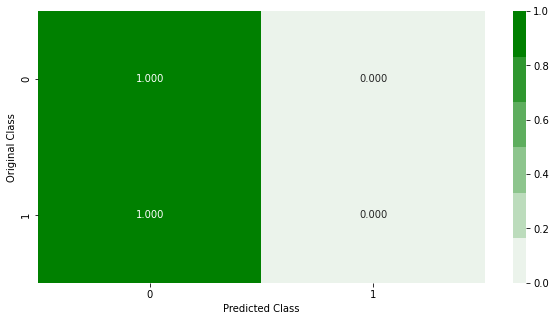

Sum of rows in precision matrix [1. 1.]
train_auc:  0.6052027716704631
test_auc:  0.5899240961286728


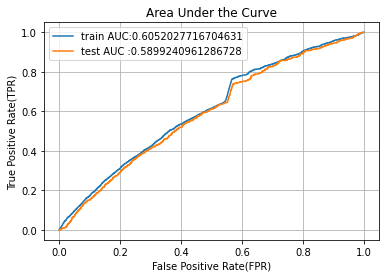

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
lg_be1=logistic_clf1.best_params_ # store the best parameters of the model
print(lg_be1)

# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_lg1 = LogisticRegression(C=lg_be1["C"],penalty=lg_be1["penalty"]) # ,class_weight=)


# train the best parameters model using train set
best_model_lg1.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_lg1.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_lg1.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_lg1.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc1 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc1)

test_auc1 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc1)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(logistic_clf1, open('logistic_clf1.pkl', 'wb'))
best_model = pickle.load(open('logistic_clf1.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("logistic_Classifier_basemodel.csv", index=False)

shape of the test dataset: (75818, 370)


## DT

In [ ]:
# Hyper parameter tuning
#depth` in range [1, 5, 10, 50]
# min_samples_split` in range [5, 10, 100, 500])
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier() # initilaize the model
# given parameters
parameters = {'max_depth': [1, 5,8,10,15,50], 'min_samples_split': [5, 10, 100, 500]}
# 5-fold cross validation with metric roc_auc
# initilaize the gridsearchcv model
DT_clf1 = GridSearchCV(DT, parameters, cv=5, scoring='roc_auc',return_train_score=True,n_jobs=-1) 
# train the model using set1 train data
DT_clf1.fit(X_train, y_train)
print(DT_clf1.best_params_)
print(DT_clf1.best_score_)
print("classification best parameters : ",DT_clf1.best_params_)
print("Best score : ",DT_clf1.best_score_)
print("="*50)
print("Train AUC scores")
print(DT_clf1.cv_results_["mean_train_score"])
print("CV AUC scores")
print(DT_clf1.cv_results_["mean_test_score"])

{'max_depth': 10, 'min_samples_split': 500}
0.8222540493962894
classification best parameters :  {'max_depth': 10, 'min_samples_split': 500}
Best score :  0.8222540493962894
Train AUC scores
[0.68618447 0.68618447 0.68618447 0.68618447 0.82724227 0.82723375
 0.82719399 0.82675186 0.85015523 0.84990002 0.84806395 0.84503779
 0.86543885 0.8647539  0.85983297 0.85433464 0.91294902 0.90983245
 0.89216205 0.87451548 0.99622106 0.98968101 0.94151991 0.89804235]
CV AUC scores
[0.68603861 0.68603861 0.68603861 0.68603861 0.81298203 0.81298236
 0.81289418 0.81291531 0.81183452 0.81295759 0.81690367 0.82199564
 0.80098515 0.80351385 0.81186217 0.82225405 0.75684647 0.76069546
 0.79469601 0.81770052 0.58902315 0.60978283 0.73426966 0.79781453]


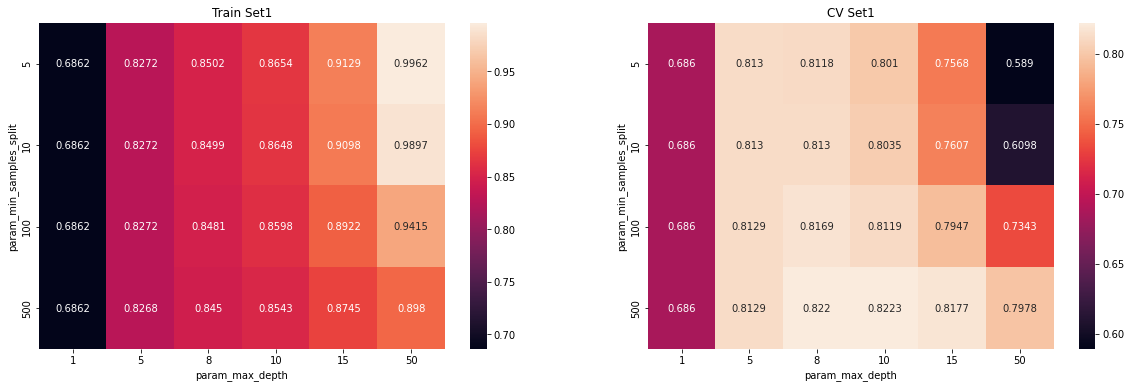

In [ ]:
max_scores2 = pd.DataFrame(DT_clf1.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores2.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores2.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set1')
ax[1].set_title('CV Set1')

plt.show()

{'max_depth': 10, 'min_samples_split': 500}
-------------------------------------------------- Confusion matrix --------------------------------------------------


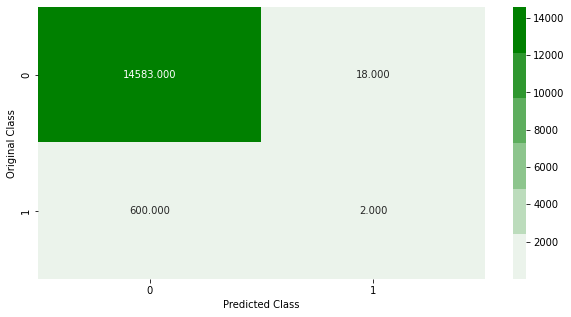

-------------------------------------------------- Precision matrix --------------------------------------------------


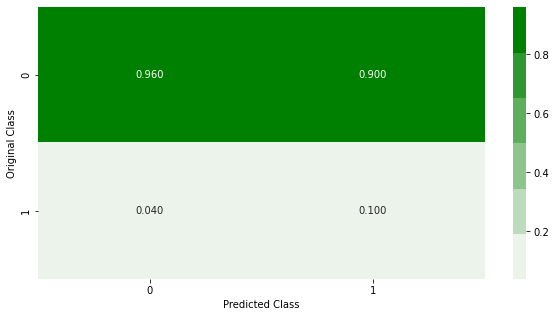

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


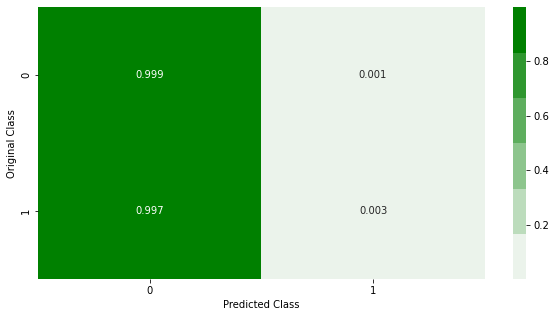

Sum of rows in precision matrix [1. 1.]
train_auc:  0.8501703287497304
test_auc:  0.8047654543299155


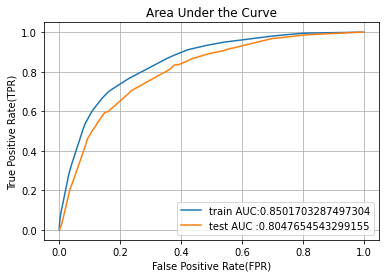

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
DT_be1=DT_clf1.best_params_ # store the best parameters of the model
print(DT_be1)
# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_DT1 = DecisionTreeClassifier(max_depth=DT_be1["max_depth"],min_samples_split=DT_be1["min_samples_split"])

# train the best parameters model using train set
best_model_DT1.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_DT1.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_DT1.predict_proba(X_test)[:,1]

y_test_predict1 = best_model_DT1.predict(X_test)

plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc2 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc2)

test_auc2 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc2)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(DT_clf1, open('DT_clf1.pkl', 'wb'))
best_model = pickle.load(open('DT_clf1.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("DT_Classifier_basemodel.csv", index=False)

shape of the test dataset: (75818, 370)


## SVM

In [ ]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model

In [ ]:
from sklearn.svm import SVC

In [ ]:
# refer for SVM : https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
from sklearn.svm import SVC
parameters = {'C': [0.001,0.1,1,10,100],'kernel': ['rbf', 'poly', 'sigmoid',"Linear"]}#,'gamma': [1,0.1,0.01,0.001]
sv = SVC()
SVM_clf1 = RandomizedSearchCV(sv,parameters,cv=5,scoring="roc_auc",return_train_score=True,n_jobs=-1)
SVM_clf1.fit(X_train,y_train)

print("classification best parameters : ",SVM_clf1.best_params_)
print("Best score : ",SVM_clf1.best_score_)
print("="*50)
print("Train AUC scores")
print(SVM_clf1.cv_results_["mean_train_score"])
print("CV AUC scores")
print(SVM_clf1.cv_results_["mean_test_score"])

classification best parameters :  {'kernel': 'rbf', 'C': 1}
Best score :  0.615072930462604
Train AUC scores
[0.55379576        nan 0.51271492 0.61104919 0.61480604 0.58935797
 0.6134993         nan 0.56004413 0.58232978]
CV AUC scores
[0.55701752        nan 0.51084236 0.61094153 0.61507293 0.5830136
 0.61272309        nan 0.56230893 0.58668298]


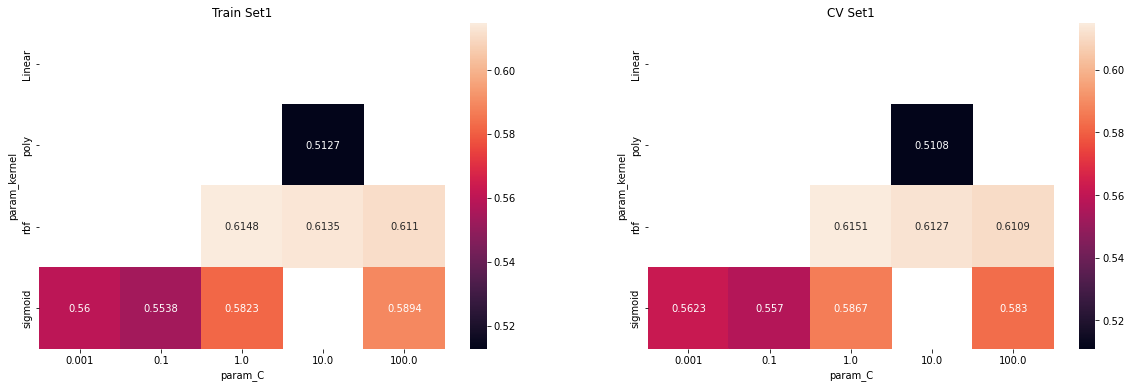

In [ ]:
max_scores3 = pd.DataFrame(SVM_clf1.cv_results_).groupby(['param_kernel', 'param_C']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores3.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores3.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set1')
ax[1].set_title('CV Set1')

plt.show()

-------------------------------------------------- Confusion matrix --------------------------------------------------


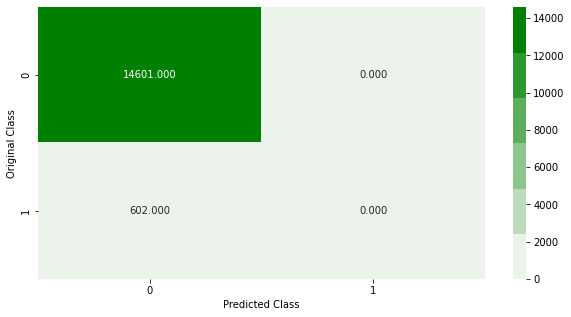

-------------------------------------------------- Precision matrix --------------------------------------------------


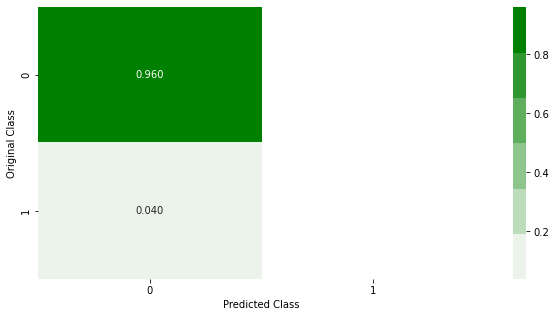

Sum of columns in precision matrix [ 1. nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


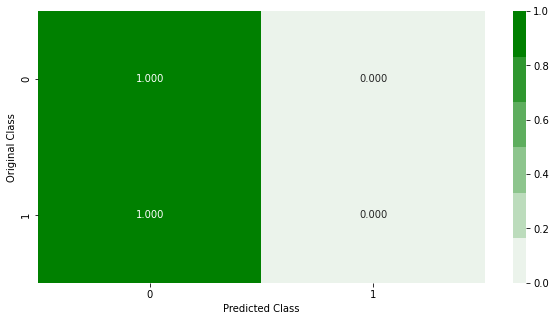

Sum of rows in precision matrix [1. 1.]
train_auc:  0.6131853599740348
test_auc:  0.6099620332744697


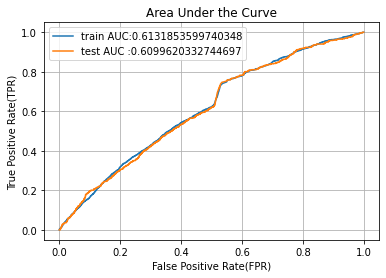

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
SVM_be1=SVM_clf1.best_params_ # store the best parameters of the model
print(SVM_be1)
# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_SVM1 = SVC(C=SVM_be1["C"],kernel=SVM_be1["kernel"],probability=True)#,gamma = SVM_be1["gamma"]

# train the best parameters model using train set
best_model_SVM1.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_SVM1.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_SVM1.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_SVM1.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc3 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc3)

test_auc3 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc3)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(logistic_clf1, open('SVM_clf1.pkl', 'wb'))
best_model = pickle.load(open('SVM_clf1.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("SVM_Classifier_basemodel.csv", index=False)

shape of the test dataset: (75818, 370)


## xgboost

In [ ]:
from sklearn.metrics import roc_curve , confusion_matrix
# GBDT ASSAIGNMENT-11
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from xgboost import XGBClassifier

gbdt = XGBClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500], 'max_depth':[2, 3, 4, 5, 6, 7, 8]}
 
Xgb_clf1 = RandomizedSearchCV(gbdt,grid_params ,cv=3,return_train_score=True, scoring='roc_auc',n_jobs=-1)
Xgb_clf1.fit(X_train, y_train)

print("cassification best parameters : ",Xgb_clf1.best_params_)

print('Best score: ',Xgb_clf1.best_score_)
print('k value with best score: ',Xgb_clf1.best_params_)
print('='*50)
print('Train AUC scores')
print(Xgb_clf1.cv_results_['mean_train_score'])
print('CV AUC scores')
print(Xgb_clf1.cv_results_['mean_test_score'])

cassification best parameters :  {'n_estimators': 100, 'max_depth': 4}
Best score:  0.8418258062637394
k value with best score:  {'n_estimators': 100, 'max_depth': 4}
Train AUC scores
[0.85567301 0.94789123 0.98195439 0.91209182 0.86164611 0.9285353
 0.88042087 0.8355745  0.92928748 0.87878184]
CV AUC scores
[0.82703204 0.82573931 0.80926387 0.84016152 0.84062862 0.83155805
 0.84182581 0.82380168 0.83526908 0.84173056]


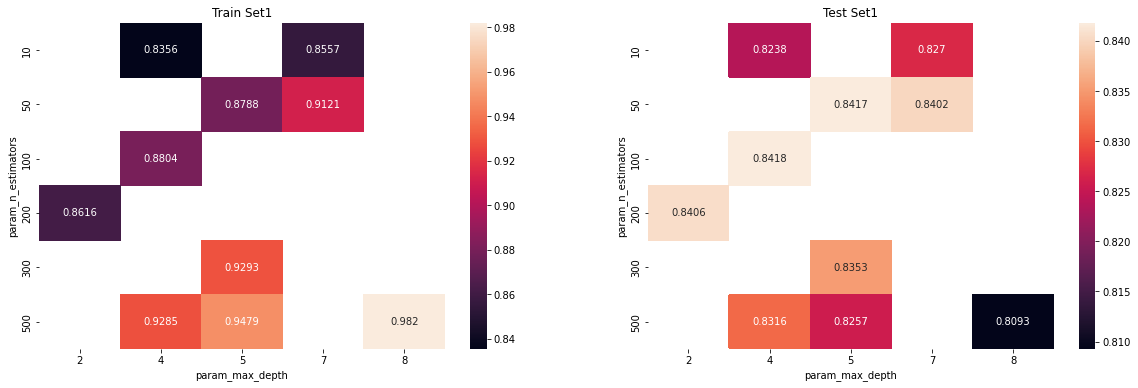

In [ ]:
max_scores4 = pd.DataFrame(Xgb_clf1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores4.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores4.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set1')
ax[1].set_title('Test Set1')

plt.show()

{'n_estimators': 100, 'max_depth': 4}
-------------------------------------------------- Confusion matrix --------------------------------------------------


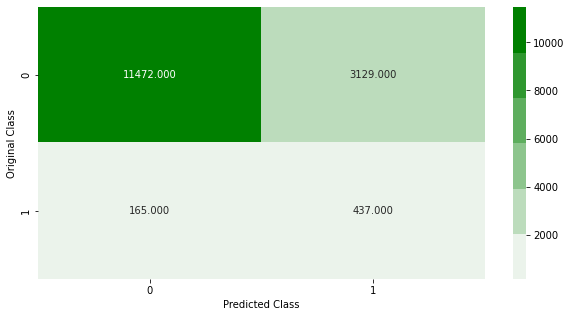

-------------------------------------------------- Precision matrix --------------------------------------------------


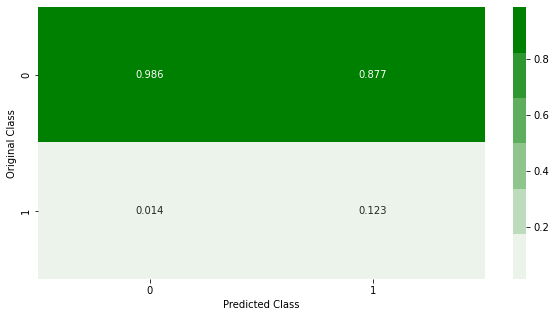

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


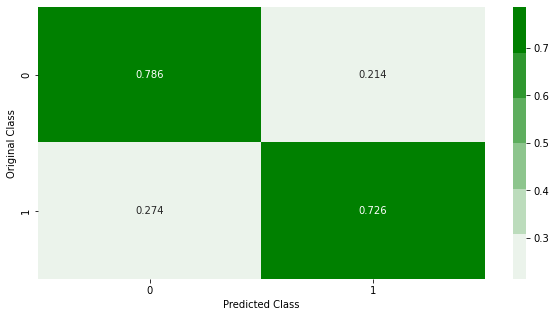

Sum of rows in precision matrix [1. 1.]
train_auc:  0.8799431353641102
test_auc:  0.8196948008612708


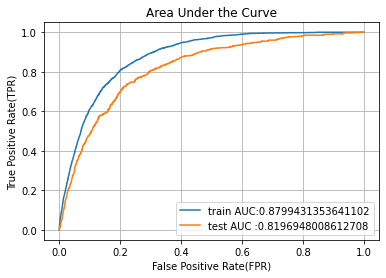

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
Xgb_be1=Xgb_clf1.best_params_ # store the best parameters of the model
print(Xgb_be1)
# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_Xgb1 = XGBClassifier(max_depth=Xgb_be1["max_depth"],n_estimators=Xgb_be1["n_estimators"],scale_pos_weight=w)


# train the best parameters model using train set
best_model_Xgb1.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_Xgb1.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_Xgb1.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_Xgb1.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc4 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc4)

test_auc4 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc4)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(Xgb_clf1, open('Xgb_clf1.pkl', 'wb'))
best_model = pickle.load(open('Xgb_clf1.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("Xgb_Classifier_base.csv", index=False)

shape of the test dataset: (75818, 370)


## random forest classifier

In [ ]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# nice explanation: https://www.javatpoint.com/machine-learning-random-forest-algorithm


from sklearn.metrics import roc_curve , confusion_matrix
# GBDT ASSAIGNMENT-11
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier  

gbdt = RandomForestClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500], 'max_depth':[2, 3, 4, 5, 6, 7, 8]}
 
RF_clf1 = RandomizedSearchCV(gbdt,grid_params ,cv=3,return_train_score=True, scoring='roc_auc',n_jobs=-1)
RF_clf1.fit(X_train, y_train)

print("cassification best parameters : ",RF_clf1.best_params_)

print('Best score: ',RF_clf1.best_score_)
print('k value with best score: ',RF_clf1.best_params_)
print('='*50)
print('Train AUC scores')
print(RF_clf1.cv_results_['mean_train_score'])
print('CV AUC scores')
print(RF_clf1.cv_results_['mean_test_score'])

cassification best parameters :  {'n_estimators': 500, 'max_depth': 7}
Best score:  0.8096591699984339
k value with best score:  {'n_estimators': 500, 'max_depth': 7}
Train AUC scores
[0.8462634  0.82311072 0.83369491 0.83437503 0.79679423 0.83150421
 0.79941685 0.82329114 0.7948539  0.75559461]
CV AUC scores
[0.80965917 0.80222033 0.80670065 0.80629093 0.78637736 0.80465685
 0.79021392 0.8023025  0.78536405 0.75111215]


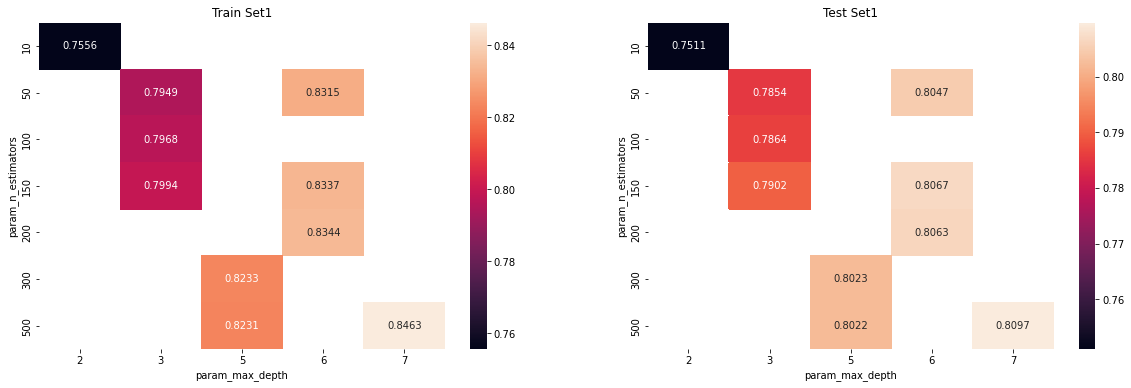

In [ ]:
max_scores5 = pd.DataFrame(RF_clf1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores5.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores5.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set1')
ax[1].set_title('Test Set1')

plt.show()

{'n_estimators': 500, 'max_depth': 7}
-------------------------------------------------- Confusion matrix --------------------------------------------------


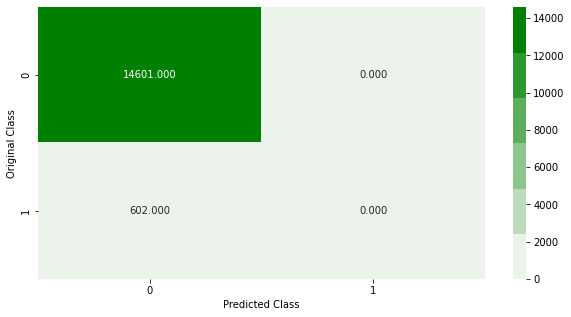

-------------------------------------------------- Precision matrix --------------------------------------------------


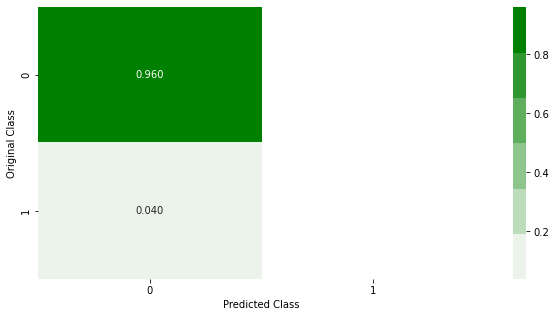

Sum of columns in precision matrix [ 1. nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


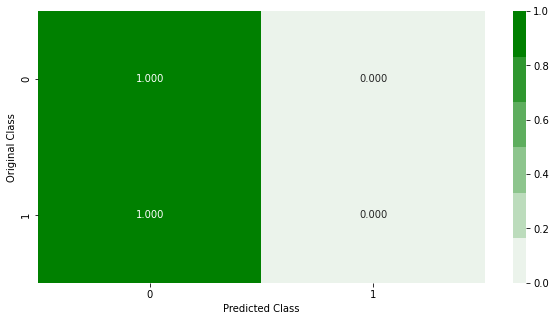

Sum of rows in precision matrix [1. 1.]
train_auc:  0.8404194444202486
test_auc:  0.7912057632242455


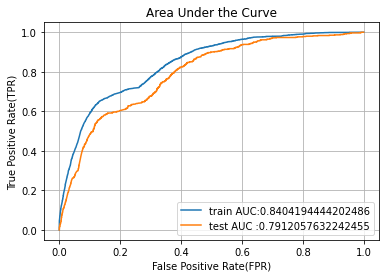

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
RF_be1=RF_clf1.best_params_ # store the best parameters of the model
print(RF_be1)
# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_RF1 = RandomForestClassifier(max_depth=RF_be1["max_depth"],n_estimators=RF_be1["n_estimators"])


# train the best parameters model using train set
best_model_RF1.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_RF1.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_RF1.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_RF1.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc5 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc5)

test_auc5 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc5)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(RF_clf1, open('RF_clf1.pkl', 'wb'))
best_model = pickle.load(open('RF_clf1.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("RF_Classifier_base.csv", index=False)

shape of the test dataset: (75818, 370)


## summary

In [ ]:
from prettytable import PrettyTable
TB1 = PrettyTable()
TB1.title = "Base"
TB1.field_names = ["Model","Train_AUC","Test_AUC"]
M1 = "logistic regression"
M2 = "Decision tree"
M3 = "support vector machine"
M4 = "Xgboost classifier"
M5 = "Random Forest classifier"
# parameters 
a1 = lg_be1
a2 = DT_be1
#a3 = SVM_be1
a4 = Xgb_be1
a5 = RF_be1
# train auc values
tr1 = train_auc1
tr2 = train_auc2
#tr3 = train_auc3
tr4 = train_auc4
tr5 = train_auc5
# test auc values
te1 = test_auc1
te2 = test_auc2
#te3 = test_auc3
te4 = test_auc4
te5 = test_auc5
# create table
TB1.add_row([M1, tr1, te1]) # a1["max_depth"] ,a1["n_estimators"],
TB1.add_row([M2, tr2, te2])
#TB1.add_row([M3, tr3, te3])
TB1.add_row([M4, tr4, te4])
TB1.add_row([M5, tr5, te5])
print(TB1)

+--------------------------------------------------------------------+
|                                Base                                |
+--------------------------+--------------------+--------------------+
|          Model           |     Train_AUC      |      Test_AUC      |
+--------------------------+--------------------+--------------------+
|   logistic regression    | 0.6052027716704631 | 0.5899240961286728 |
|      Decision tree       | 0.8501703287497304 | 0.8047654543299155 |
|    Xgboost classifier    | 0.8799431353641102 | 0.8196948008612708 |
| Random Forest classifier | 0.8404194444202486 | 0.7912057632242455 |
+--------------------------+--------------------+--------------------+


# SMOTE

In [ ]:
dataset_analysis(dataframe_train)

This dataset having 76013 rows and 251 columns.
dataset have 0 integer type & 251 float type & 0 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 76013 entries, 0 to 76019
Columns: 251 entries, ID to TARGET
dtypes: float64(251)
memory usage: 148.6 MB
None
--------------------------------------------------


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var41_0,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_var7_recib_ult1,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var39_vig_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_comer_ult1,num_op_var41_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto

In [ ]:
X = dataframe_train.drop(["ID","TARGET"],axis=1)
Y = dataframe_train["TARGET"]

In [ ]:
from sklearn.model_selection import train_test_split
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(X,Y,stratify=Y,test_size=0.20)

print('Number of data points in train data:', X_train.shape)
print('Number of data points in test data:', X_test.shape)

Number of data points in train data: (60810, 249)
Number of data points in test data: (15203, 249)


In [ ]:
from imblearn.over_sampling import ADASYN,SMOTE
from collections import Counter
counter = Counter(y_train)
print("before sampling : ",counter)
# transform the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)
print("after sampling",counter)

before sampling :  Counter({0.0: 58404, 1.0: 2406})
after sampling Counter({0.0: 58404, 1.0: 58404})


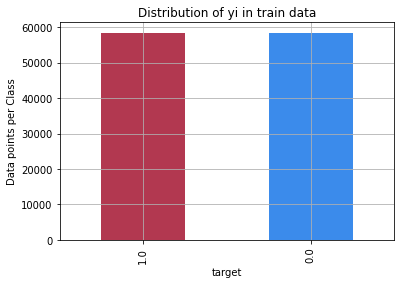

Number of data points in class 1 : 58404 ( 50.0 %)
Number of data points in class 2 : 58404 ( 50.0 %)
--------------------------------------------------------------------------------


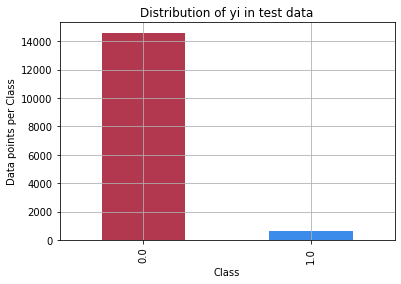

Number of data points in class 1 : 14601 ( 96.04 %)
Number of data points in class 2 : 602 ( 3.96 %)


In [ ]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts()
test_class_distribution = y_test.value_counts()

my_colors = ['#b23850', '#3b8beb'] #, '#e7e3d4', '#c4dbf6', '#8590aa', '#0d19a3', '#15db95', '#080f5b', '#f79e02']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('target')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = ['#b23850', '#3b8beb'] # , '#e7e3d4', '#c4dbf6', '#8590aa', '#0d19a3', '#15db95', '#080f5b', '#f79e02']
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')


## logistic regression

In [ ]:
# logistic regression refer : https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35
# solvers in logistic regression : https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
grid_params1 = {"penalty":["l1","l2","none"],"C":[10**x for x in range(-5,4)]} # ,"elasticnet"
logistic_clf2 = RandomizedSearchCV(lg,grid_params1,cv=5,return_train_score=True,scoring="roc_auc",n_jobs=-1)
logistic_clf2.fit(X_train,y_train)

print("classification best parameters : ",logistic_clf2.best_params_)
print("Best score : ",logistic_clf2.best_score_)
print("="*50)
print("Train AUC scores")
print(logistic_clf2.cv_results_["mean_train_score"])
print("CV AUC scores")
print(logistic_clf2.cv_results_["mean_test_score"])

classification best parameters :  {'penalty': 'l2', 'C': 10}
Best score :  0.6253402814236175
Train AUC scores
[0.62517478        nan 0.62517478 0.62517478        nan        nan
 0.62517478        nan 0.62517475 0.62517475]
CV AUC scores
[0.62534005        nan 0.62534006 0.62534005        nan        nan
 0.62534005        nan 0.62534028 0.62534026]


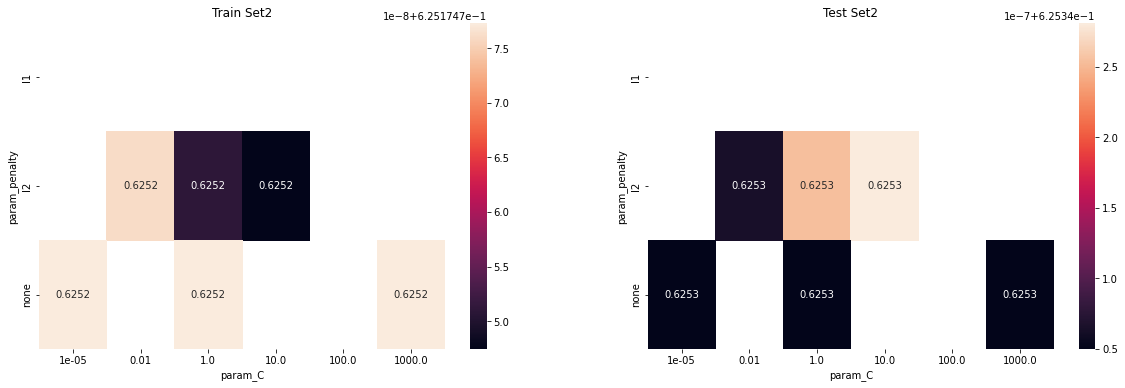

In [ ]:
max_scores21 = pd.DataFrame(logistic_clf2.cv_results_).groupby(['param_penalty', 'param_C']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores21.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores21.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set2')
ax[1].set_title('Test Set2')

plt.show()

{'penalty': 'l2', 'C': 10}
-------------------------------------------------- Confusion matrix --------------------------------------------------


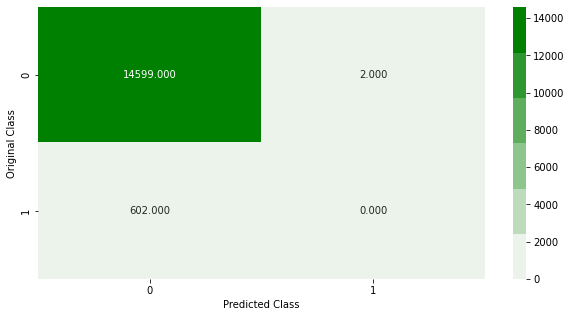

-------------------------------------------------- Precision matrix --------------------------------------------------


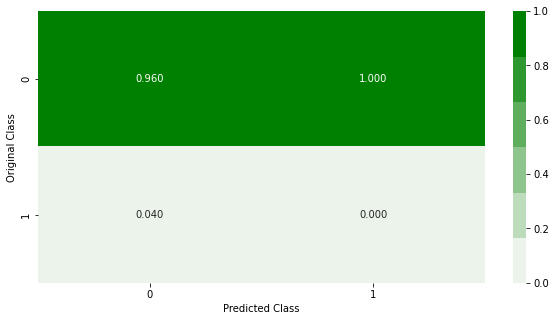

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


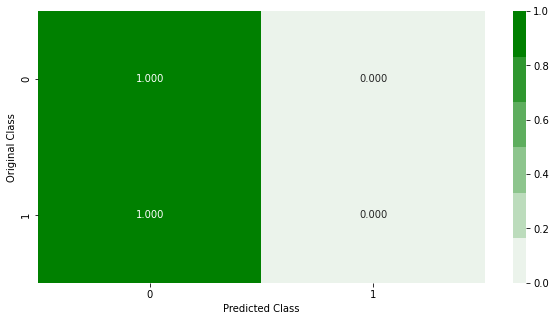

Sum of rows in precision matrix [1. 1.]
train_auc:  0.6327368265712483
test_auc:  0.6319070668486048


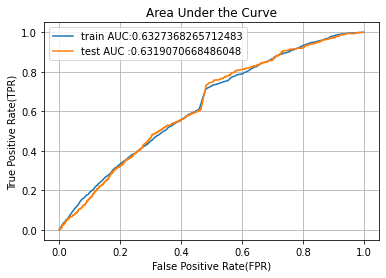

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
lg_be2=logistic_clf2.best_params_ # store the best parameters of the model
print(lg_be2)

# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_lg2 = LogisticRegression(C=lg_be2["C"],penalty=lg_be2["penalty"]) # ,class_weight=)


# train the best parameters model using train set
best_model_lg2.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_lg2.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_lg2.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_lg2.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc21 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc21)

test_auc21 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc21)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(logistic_clf2, open('logistic_clf2.pkl', 'wb'))
best_model = pickle.load(open('logistic_clf2.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("logistic_Classifier_SMOTE.csv", index=False)

shape of the test dataset: (75818, 370)


## DT

In [ ]:
# Hyper parameter tuning
#depth` in range [1, 5, 10, 50]
# min_samples_split` in range [5, 10, 100, 500])
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier() # initilaize the model
# given parameters
parameters = {'max_depth': [1, 5,8,10,15,50], 'min_samples_split': [5, 10, 100, 500]}
# 5-fold cross validation with metric roc_auc
# initilaize the gridsearchcv model
DT_clf2 = GridSearchCV(DT, parameters, cv=5, scoring='roc_auc',return_train_score=True,n_jobs=-1) 
# train the model using set1 train data
DT_clf2.fit(X_train, y_train)
print(DT_clf2.best_params_)
print(DT_clf2.best_score_)
print("classification best parameters : ",DT_clf2.best_params_)
print("Best score : ",DT_clf2.best_score_)
print("="*50)
print("Train AUC scores")
print(DT_clf2.cv_results_["mean_train_score"])
print("CV AUC scores")
print(DT_clf2.cv_results_["mean_test_score"])

{'max_depth': 50, 'min_samples_split': 100}
0.9792722035377823
classification best parameters :  {'max_depth': 50, 'min_samples_split': 100}
Best score :  0.9792722035377823
Train AUC scores
[0.75066776 0.75066776 0.75066776 0.75066776 0.92284608 0.92284608
 0.92283051 0.92277564 0.9626531  0.96263461 0.96224771 0.96094818
 0.97539637 0.97532183 0.97423022 0.97129617 0.99061451 0.9902067
 0.98569934 0.97781493 0.99920013 0.99860435 0.99180087 0.98163633]
CV AUC scores
[0.7506678  0.7506678  0.7506678  0.7506678  0.92173811 0.92173811
 0.92173775 0.92173086 0.95942187 0.95949111 0.95939851 0.95863462
 0.96985438 0.96999869 0.9701235  0.96855823 0.97310137 0.97434799
 0.97731885 0.97354129 0.96361153 0.96855609 0.9792722  0.9754631 ]


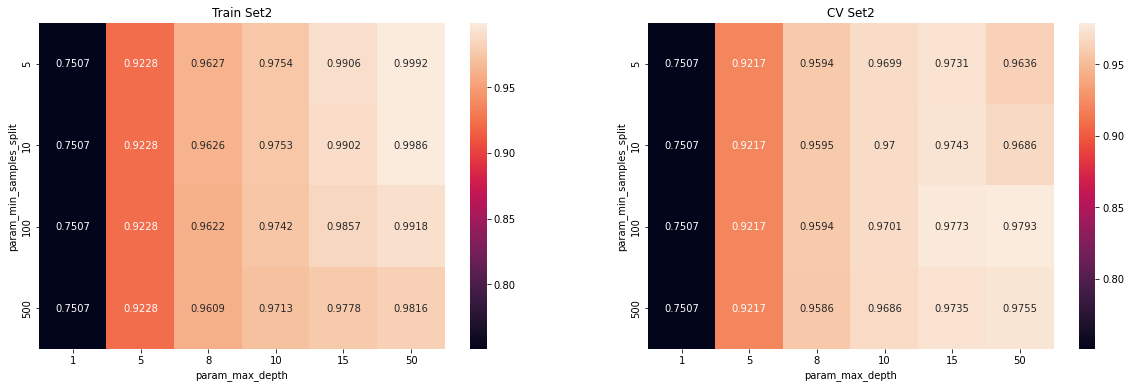

In [ ]:
max_scores22 = pd.DataFrame(DT_clf2.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores22.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores22.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set2')
ax[1].set_title('CV Set2')

plt.show()

{'max_depth': 50, 'min_samples_split': 100}
-------------------------------------------------- Confusion matrix --------------------------------------------------


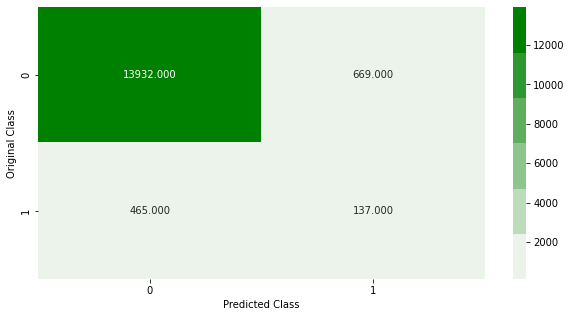

-------------------------------------------------- Precision matrix --------------------------------------------------


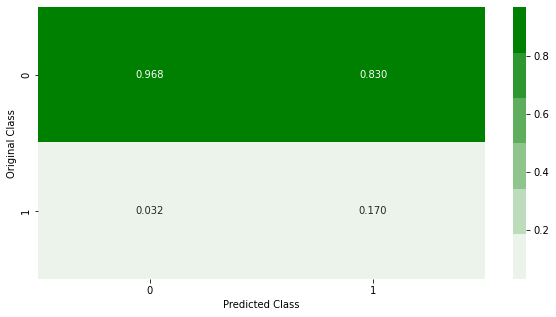

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


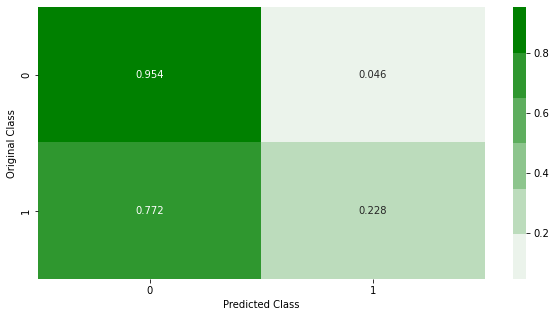

Sum of rows in precision matrix [1. 1.]
train_auc:  0.9924761617615896
test_auc:  0.7428659371394258


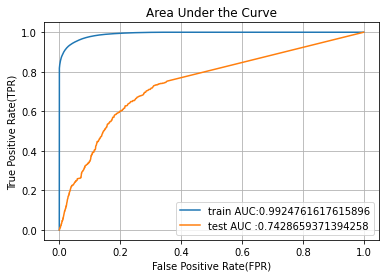

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
DT_be2=DT_clf2.best_params_ # store the best parameters of the model
print(DT_be2)
# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_DT2 = DecisionTreeClassifier(max_depth=DT_be2["max_depth"],min_samples_split=DT_be2["min_samples_split"])

# train the best parameters model using train set
best_model_DT2.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_DT2.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_DT2.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_DT2.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc22 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc22)

test_auc22 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc22)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(DT_clf2, open('DT_clf2.pkl', 'wb'))
best_model = pickle.load(open('DT_clf2.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("DT_Classifier_SMOTE.csv", index=False)

shape of the test dataset: (75818, 370)


## SVM

In [ ]:
# refer for SVM : https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
parameters = {'C': [0.001,0.1,1, 10, 100],'kernel': ['rbf', 'poly',"Linear"]}#, 'gamma': [1,0.1,0.01,0.001] #,'sigmoid'
sv = SVC()
SVM_clf2 = RandomizedSearchCV(sv,parameters,cv=3,scoring="roc_auc",return_train_score=True,n_jobs=-1)
SVM_clf2.fit(X_train,y_train)

print("classification best parameters : ",SVM_clf2.best_params_)
print("Best score : ",SVM_clf2.best_score_)
print("="*50)
print("Train AUC scores")
print(SVM_clf2.cv_results_["mean_train_score"])
print("CV AUC scores")
print(SVM_clf2.cv_results_["mean_test_score"])

In [ ]:
max_scores23 = pd.DataFrame(SVM_clf2.cv_results_).groupby(['param_kernel', 'param_C']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores23.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores23.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set2')
ax[1].set_title('CV Set2')

plt.show()

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
SVM_be2=SVM_clf2.best_params_ # store the best parameters of the model
print(SVM_be2)
# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_SVM2 = SVC(C=SVM_be2["C"],kernel=SVM_be2["kernel"],probability=True)#,gamma = SVM_be2["gamma"]

# train the best parameters model using train set
best_model_SVM2.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_SVM2.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_SVM2.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_SVM2.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc23 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc23)

test_auc23 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc23)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(SVM_clf2, open('SVM_clf2.pkl', 'wb'))
best_model = pickle.load(open('SVM_clf2.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("SVM_Classifier_SMOTE.csv", index=False)

NameError: ignored

## xgboost

In [ ]:
from sklearn.metrics import roc_curve , confusion_matrix
import sklearn

# GBDT ASSAIGNMENT-11
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from xgboost import XGBClassifier

gbdt = XGBClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500], 'max_depth':[2, 3, 4, 5, 6, 7, 8]}
 
Xgb_clf2 = RandomizedSearchCV(gbdt,grid_params ,cv=3,return_train_score=True, scoring='roc_auc',n_jobs=-1)
Xgb_clf2.fit(X_train, y_train)

print("cassification best parameters : ",Xgb_clf2.best_params_)

print('Best score: ',Xgb_clf2.best_score_)
print('k value with best score: ',Xgb_clf2.best_params_)
print('='*50)
print('Train AUC scores')
print(Xgb_clf2.cv_results_['mean_train_score'])
print('CV AUC scores')
print(Xgb_clf2.cv_results_['mean_test_score'])

cassification best parameters :  {'n_estimators': 100, 'max_depth': 8}
Best score:  0.9896166386964413
k value with best score:  {'n_estimators': 100, 'max_depth': 8}
Train AUC scores
[0.89399371 0.98002666 0.96983481 0.98296497 0.99364552 0.98535277
 0.99035081 0.94763774 0.94349001 0.9867616 ]
CV AUC scores
[0.89353753 0.97893545 0.96856598 0.98128223 0.98961664 0.98378663
 0.98746017 0.94721078 0.94292544 0.98515981]


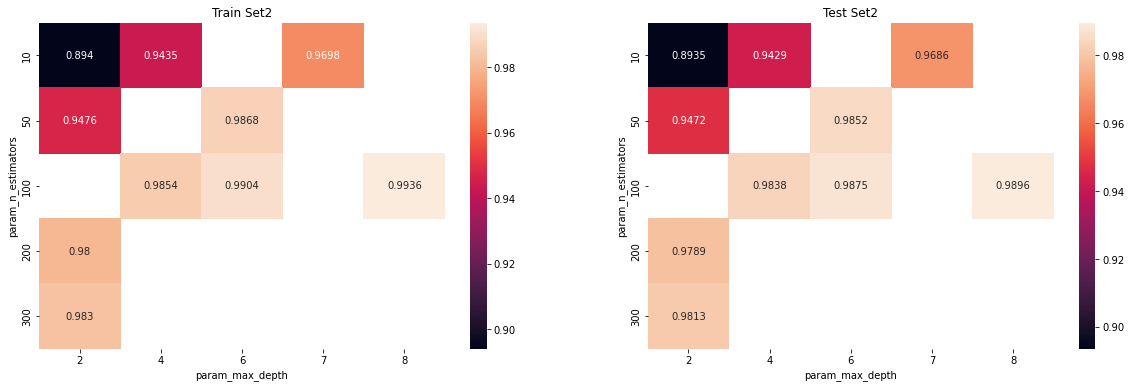

In [ ]:
max_scores24 = pd.DataFrame(Xgb_clf2.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores24.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores24.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set2')
ax[1].set_title('Test Set2')

plt.show()

{'n_estimators': 100, 'max_depth': 8}
-------------------------------------------------- Confusion matrix --------------------------------------------------


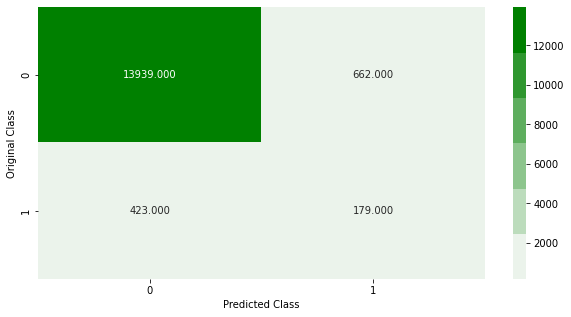

-------------------------------------------------- Precision matrix --------------------------------------------------


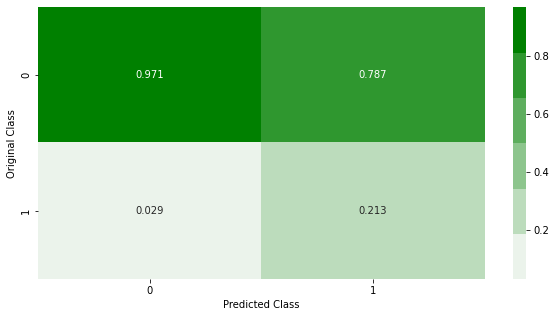

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


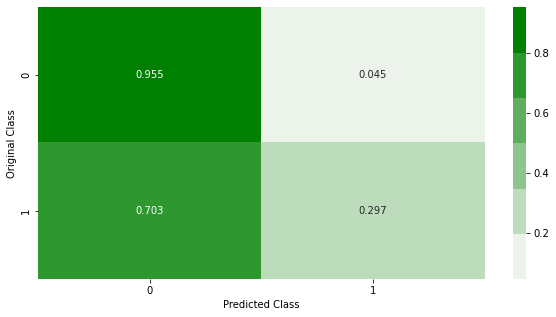

Sum of rows in precision matrix [1. 1.]
train_auc:  0.9933970991511432
test_auc:  0.8179909513320095


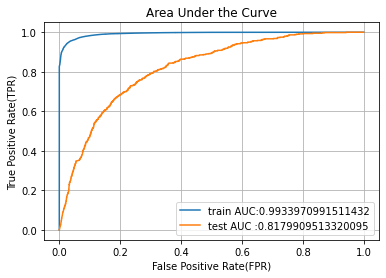

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
Xgb_be2=Xgb_clf2.best_params_ # store the best parameters of the model
print(Xgb_be2)
# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_Xgb2 = XGBClassifier(max_depth=Xgb_be2["max_depth"],n_estimators=Xgb_be2["n_estimators"],scale_pos_weight=w)


# train the best parameters model using train set
best_model_Xgb2.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_Xgb2.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_Xgb2.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_Xgb2.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc24 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc24)

test_auc24 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc24)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(Xgb_clf2, open('Xgb_clf2.pkl', 'wb'))
best_model = pickle.load(open('Xgb_clf2.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("Xgb_Classifier_SMOTE.csv", index=False)

shape of the test dataset: (75818, 370)


## RF

In [ ]:
from sklearn.metrics import roc_curve , confusion_matrix
import sklearn

# GBDT ASSAIGNMENT-11
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier

gbdt = RandomForestClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500], 'max_depth':[2, 3, 4, 5, 6, 7, 8]}
 
RF_clf2 = RandomizedSearchCV(gbdt,grid_params ,cv=3,return_train_score=True, scoring='roc_auc',n_jobs=-1)
RF_clf2.fit(X_train, y_train)

print("cassification best parameters : ",RF_clf2.best_params_)

print('Best score: ',RF_clf2.best_score_)
print('k value with best score: ',RF_clf2.best_params_)
print('='*50)
print('Train AUC scores')
print(RF_clf2.cv_results_['mean_train_score'])
print('CV AUC scores')
print(RF_clf2.cv_results_['mean_test_score'])

cassification best parameters :  {'n_estimators': 150, 'max_depth': 8}
Best score:  0.9551593802058952
k value with best score:  {'n_estimators': 150, 'max_depth': 8}
Train AUC scores
[0.8815909  0.95671396 0.94331569 0.95517882 0.92455937 0.88121458
 0.9530872  0.94718299 0.88020641 0.94744445]
CV AUC scores
[0.88125155 0.95515938 0.94191401 0.95361571 0.92402976 0.88079951
 0.95132992 0.94588391 0.87992084 0.9462083 ]


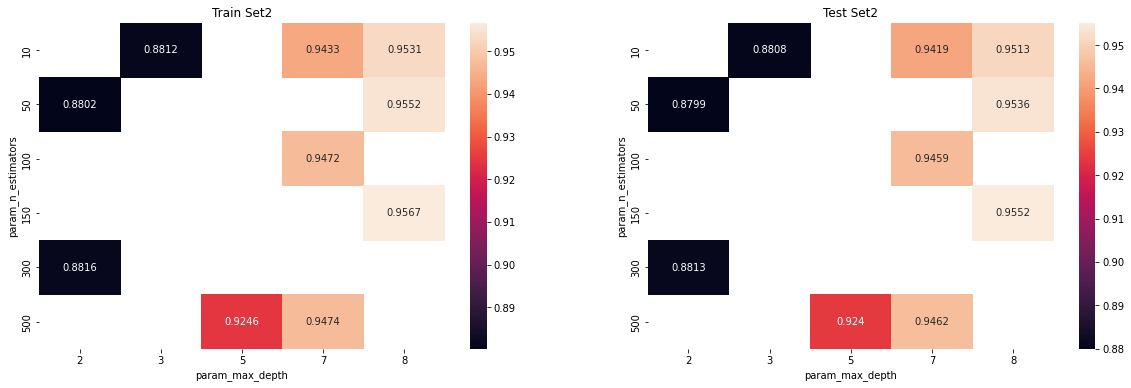

In [ ]:
max_scores25 = pd.DataFrame(RF_clf2.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores25.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores25.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set2')
ax[1].set_title('Test Set2')

plt.show()

{'n_estimators': 150, 'max_depth': 8}
-------------------------------------------------- Confusion matrix --------------------------------------------------


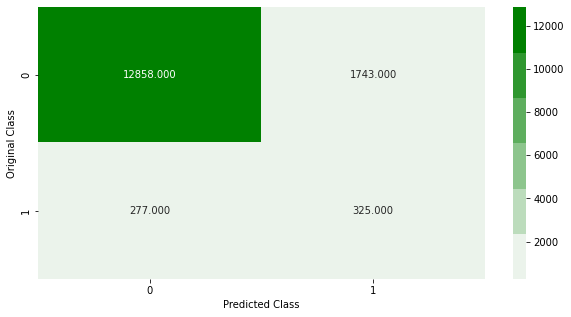

-------------------------------------------------- Precision matrix --------------------------------------------------


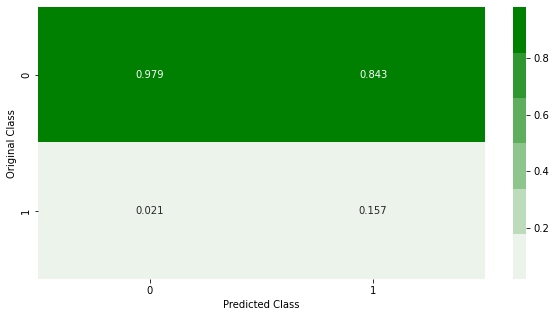

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


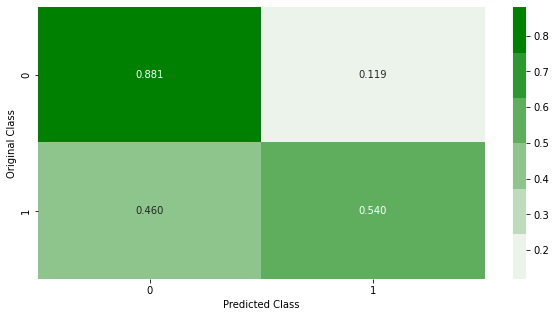

Sum of rows in precision matrix [1. 1.]
train_auc:  0.9558092007319826
test_auc:  0.7895791054223974


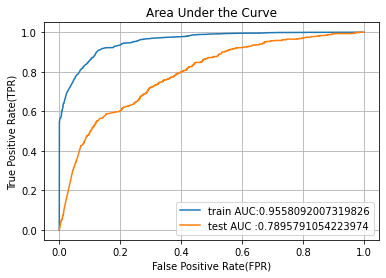

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
RF_be2=RF_clf2.best_params_ # store the best parameters of the model
print(RF_be2)
# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_RF2 = RandomForestClassifier(max_depth=RF_be2["max_depth"],n_estimators=RF_be2["n_estimators"])


# train the best parameters model using train set
best_model_RF2.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_RF2.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_RF2.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_RF2.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc25 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc25)

test_auc25 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc25)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(RF_clf2, open('RF_clf2.pkl', 'wb'))
best_model = pickle.load(open('RF_clf2.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("RF_Classifier_SMOTE.csv", index=False)

shape of the test dataset: (75818, 370)


## summary

In [ ]:
from prettytable import PrettyTable
TB2 = PrettyTable()
TB2.title = "SMOTE"
TB2.field_names = ["Model","Train_AUC","Test_AUC"]
M1 = "logistic regression"
M2 = "Decision tree"
#M3 = "support vector machine"
M4 = "Xgboost classifier"
M5 = "Random Forest Classifier"
# parameters 
a21 = lg_be2
a22 = DT_be2
#a23 = SVM_be2
a24 = Xgb_be2
a25 = RF_be2
# train auc values
tr21 = train_auc21
tr22 = train_auc22
#tr23 = train_auc23
tr24 = train_auc24
tr25 = train_auc25

# test auc values
te21 = test_auc21
te22 = test_auc22
#te23 = test_auc23
te24 = test_auc24
te25 = test_auc25
# create table
TB2.add_row([M1, tr21, te21]) # a1["max_depth"] ,a1["n_estimators"],
TB2.add_row([M2, tr22, te22])
#TB2.add_row([M3, tr23, te23])
TB2.add_row([M4, tr24, te24])
TB2.add_row([M5, tr25, te25])

print(TB2)

+--------------------------------------------------------------------+
|                               SMOTE                                |
+--------------------------+--------------------+--------------------+
|          Model           |     Train_AUC      |      Test_AUC      |
+--------------------------+--------------------+--------------------+
|   logistic regression    | 0.6327368265712483 | 0.6319070668486048 |
|      Decision tree       | 0.9924761617615896 | 0.7428659371394258 |
|    Xgboost classifier    | 0.9933970991511432 | 0.8179909513320095 |
| Random Forest Classifier | 0.9558092007319826 | 0.7895791054223974 |
+--------------------------+--------------------+--------------------+


# Adasyn

In [ ]:
dataset_analysis(dataframe_train)

This dataset having 76013 rows and 251 columns.
dataset have 0 integer type & 251 float type & 0 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 76013 entries, 0 to 76019
Columns: 251 entries, ID to TARGET
dtypes: float64(251)
memory usage: 148.6 MB
None
--------------------------------------------------


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var41_0,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_var7_recib_ult1,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var39_vig_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_comer_ult1,num_op_var41_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto

In [ ]:
X = dataframe_train.drop(["ID","TARGET"],axis=1)
Y = dataframe_train["TARGET"]

In [ ]:
from sklearn.model_selection import train_test_split
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(X,Y,stratify=Y,test_size=0.20)

print('Number of data points in train data:', X_train.shape)
print('Number of data points in test data:', X_test.shape)

Number of data points in train data: (60810, 249)
Number of data points in test data: (15203, 249)


In [ ]:
from imblearn.over_sampling import ADASYN
from collections import Counter
counter = Counter(y_train)
print("before sampling : ",counter)
# transform the dataset
oversample = ADASYN()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)
print("after sampling",counter)

before sampling :  Counter({0.0: 58404, 1.0: 2406})
after sampling Counter({0.0: 58404, 1.0: 57336})


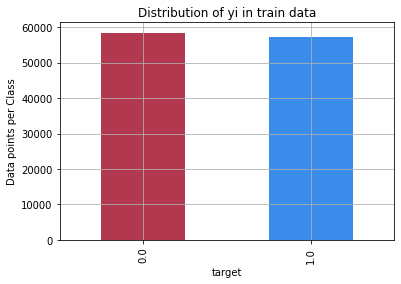

Number of data points in class 1 : 58404 ( 50.461 %)
Number of data points in class 2 : 57336 ( 49.539 %)
--------------------------------------------------------------------------------


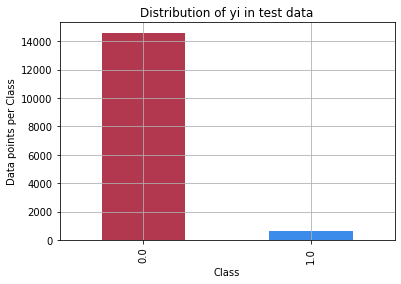

Number of data points in class 1 : 14601 ( 96.04 %)
Number of data points in class 2 : 602 ( 3.96 %)


In [ ]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts()
test_class_distribution = y_test.value_counts()

my_colors = ['#b23850', '#3b8beb'] #, '#e7e3d4', '#c4dbf6', '#8590aa', '#0d19a3', '#15db95', '#080f5b', '#f79e02']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('target')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = ['#b23850', '#3b8beb'] # , '#e7e3d4', '#c4dbf6', '#8590aa', '#0d19a3', '#15db95', '#080f5b', '#f79e02']
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')


## logistic regression

In [ ]:
# logistic regression refer : https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35
# solvers in logistic regression : https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
grid_params1 = {"penalty":["l1","l2"],"C":[10**x for x in range(-5,4)]} # ,"elasticnet"
logistic_clf3 = RandomizedSearchCV(lg,grid_params1,cv=5,return_train_score=True,scoring="roc_auc",n_jobs=-1)
logistic_clf3.fit(X_train,y_train)

print("classification best parameters : ",logistic_clf3.best_params_)
print("Best score : ",logistic_clf3.best_score_)
print("="*50)
print("Train AUC scores")
print(logistic_clf3.cv_results_["mean_train_score"])
print("CV AUC scores")
print(logistic_clf3.cv_results_["mean_test_score"])

classification best parameters :  {'penalty': 'l2', 'C': 0.01}
Best score :  0.618630506292338
Train AUC scores
[       nan        nan        nan        nan        nan 0.61706611
 0.61887846        nan        nan        nan]
CV AUC scores
[       nan        nan        nan        nan        nan 0.61607834
 0.61863051        nan        nan        nan]


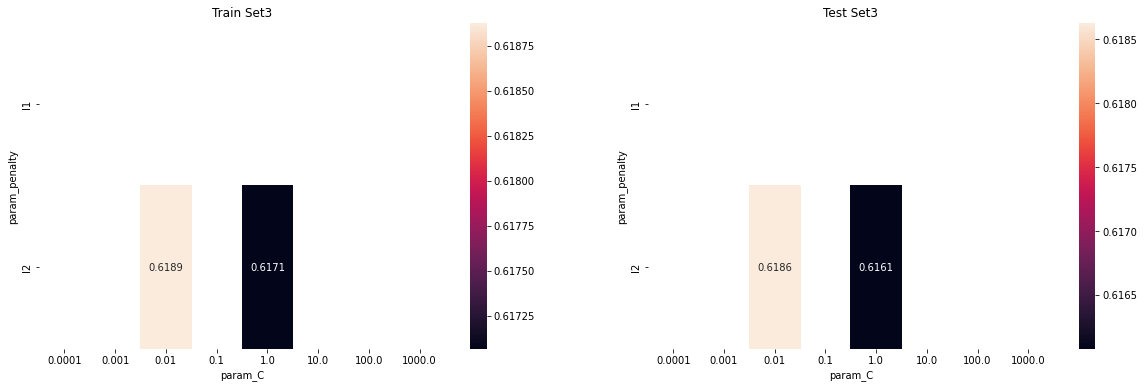

In [ ]:
max_scores31 = pd.DataFrame(logistic_clf3.cv_results_).groupby(['param_penalty', 'param_C']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores31.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores31.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set3')
ax[1].set_title('Test Set3')

plt.show()

{'penalty': 'l2', 'C': 0.01}
-------------------------------------------------- Confusion matrix --------------------------------------------------


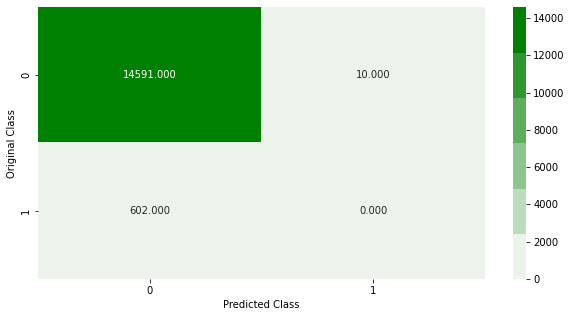

-------------------------------------------------- Precision matrix --------------------------------------------------


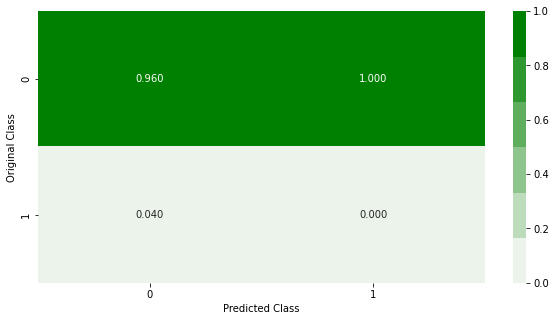

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


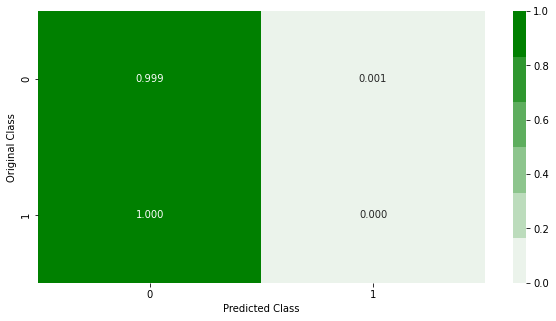

Sum of rows in precision matrix [1. 1.]
train_auc:  0.6274226712150186
test_auc:  0.6178235300408359


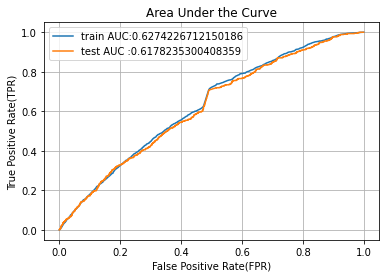

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
lg_be3=logistic_clf3.best_params_ # store the best parameters of the model
print(lg_be3)

# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_lg3 = LogisticRegression(C=lg_be3["C"],penalty=lg_be3["penalty"]) # ,class_weight=)


# train the best parameters model using train set
best_model_lg3.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_lg3.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_lg3.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_lg3.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc31 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc31)

test_auc31 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc31)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(logistic_clf3, open('logistic_clf3.pkl', 'wb'))
best_model = pickle.load(open('logistic_clf3.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("logistic_Classifier_ADASYN.csv", index=False)

shape of the test dataset: (75818, 370)


## DT

In [ ]:
# Hyper parameter tuning
#depth` in range [1, 5, 10, 50]
# min_samples_split` in range [5, 10, 100, 500])
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier() # initilaize the model
# given parameters
parameters = {'max_depth': [1, 5,8,10,15,50], 'min_samples_split': [5, 10, 100, 500]}
# 5-fold cross validation with metric roc_auc
# initilaize the gridsearchcv model
DT_clf3 = GridSearchCV(DT, parameters, cv=5, scoring='roc_auc',return_train_score=True,n_jobs=-1) 
# train the model using set1 train data
DT_clf3.fit(X_train, y_train)
print(DT_clf3.best_params_)
print(DT_clf3.best_score_)
print("classification best parameters : ",DT_clf3.best_params_)
print("Best score : ",DT_clf3.best_score_)
print("="*50)
print("Train AUC scores")
print(DT_clf3.cv_results_["mean_train_score"])
print("CV AUC scores")
print(DT_clf3.cv_results_["mean_test_score"])

{'max_depth': 50, 'min_samples_split': 100}
0.9707673611066554
classification best parameters :  {'max_depth': 50, 'min_samples_split': 100}
Best score :  0.9707673611066554
Train AUC scores
[0.74577447 0.74577447 0.74577447 0.74577447 0.9173601  0.9173601
 0.9173601  0.9173601  0.95903401 0.95900252 0.95860999 0.95727056
 0.9737971  0.97371318 0.97271263 0.96897964 0.99115255 0.99076998
 0.98662902 0.97683766 0.999284   0.99864111 0.99176187 0.97940168]
CV AUC scores
[0.74576569 0.74576569 0.74576569 0.74576569 0.91358183 0.91358183
 0.91365103 0.91358183 0.95166562 0.95160809 0.95153952 0.95071407
 0.96315633 0.96345386 0.96342446 0.96133757 0.96458071 0.96585231
 0.97066655 0.96754714 0.95069753 0.95693901 0.97076736 0.96745009]


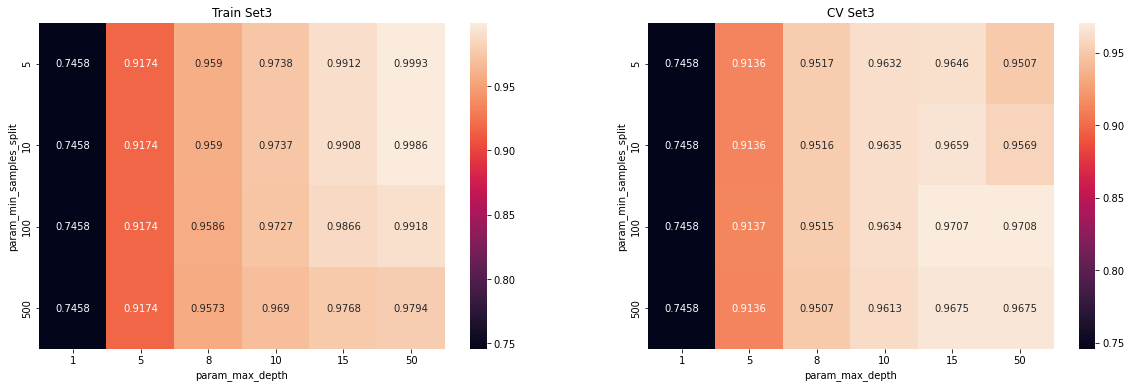

In [ ]:
max_scores32 = pd.DataFrame(DT_clf3.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores32.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores32.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set3')
ax[1].set_title('CV Set3')

plt.show()

{'max_depth': 50, 'min_samples_split': 100}
-------------------------------------------------- Confusion matrix --------------------------------------------------


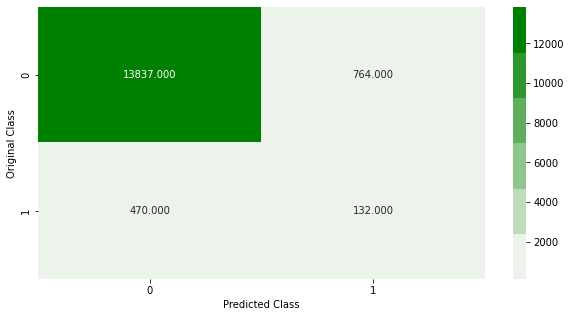

-------------------------------------------------- Precision matrix --------------------------------------------------


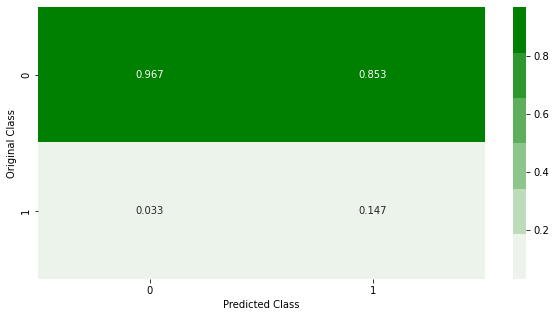

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


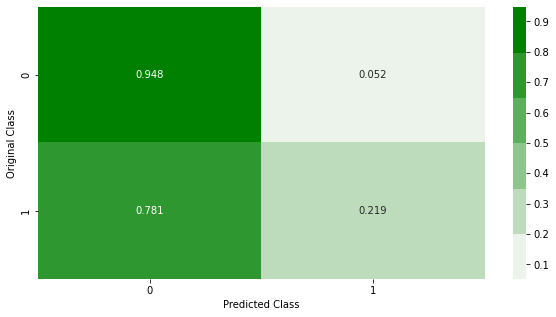

Sum of rows in precision matrix [1. 1.]
train_auc:  0.9920200102479346
test_auc:  0.7467399151880781


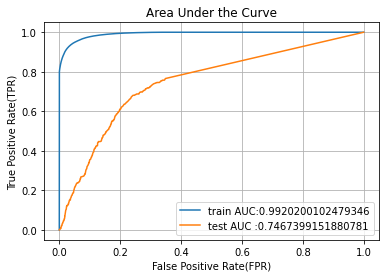

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
DT_be3=DT_clf3.best_params_ # store the best parameters of the model
print(DT_be3)
# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_DT3 = DecisionTreeClassifier(max_depth=DT_be3["max_depth"],min_samples_split=DT_be3["min_samples_split"])

# train the best parameters model using train set
best_model_DT3.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_DT3.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_DT3.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_DT3.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc32 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc32)

test_auc32 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc32)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(DT_clf3, open('DT_clf3.pkl', 'wb'))
best_model = pickle.load(open('DT_clf3.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("DT_Classifier_ADASYN.csv", index=False)

shape of the test dataset: (75818, 370)


## SVM

In [ ]:
# refer for SVM : https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
from sklearn.svm import SVC
parameters = {'C': [0.001,0.1,1,10,100],'kernel': ['rbf', 'poly', 'sigmoid',"Linear"]}#, 'gamma': [1,0.1,0.01,0.001]
sv = SVC()
SVM_clf3 = RandomizedSearchCV(sv,parameters,cv=5,scoring="roc_auc",return_train_score=True,n_jobs=-1)
SVM_clf3.fit(X_train,y_train)

print("classification best parameters : ",SVM_clf3.best_params_)
print("Best score : ",SVM_clf3.best_score_)
print("="*50)
print("Train AUC scores")
print(SVM_clf3.cv_results_["mean_train_score"])
print("CV AUC scores")
print(SVM_clf3.cv_results_["mean_test_score"])

In [ ]:
max_scores33 = pd.DataFrame(SVM_clf3.cv_results_).groupby(['param_kernel', 'param_C']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores33.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores33.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set3')
ax[1].set_title('CV Set3')

plt.show()

NameError: ignored

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
SVM_be3=SVM_clf3.best_params_ # store the best parameters of the model
print(SVM_be3)
# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_SVM3 = SVC(C=SVM_be3["C"],kernel=SVM_be3["kernel"],probability=True)#,gamma = SVM_be1["gamma"]

# train the best parameters model using train set
best_model_SVM3.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_SVM3.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_SVM3.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_SVM3.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc33 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc33)

test_auc33 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc33)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(SVM_clf3, open('SVM_clf3.pkl', 'wb'))
best_model = pickle.load(open('SVM_clf3.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("SVM_Classifier_ADASYN.csv", index=False)

## xgboost

In [ ]:
from sklearn.metrics import roc_curve , confusion_matrix
import sklearn

# GBDT ASSAIGNMENT-11
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from xgboost import XGBClassifier

gbdt = XGBClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500], 'max_depth':[2, 3, 4, 5, 6, 7, 8]}
 
Xgb_clf3 = RandomizedSearchCV(gbdt,grid_params ,cv=3,return_train_score=True, scoring='roc_auc',n_jobs=-1)
Xgb_clf3.fit(X_train, y_train)

print("cassification best parameters : ",Xgb_clf3.best_params_)

print('Best score: ',Xgb_clf3.best_score_)
print('k value with best score: ',Xgb_clf3.best_params_)
print('='*50)
print('Train AUC scores')
print(Xgb_clf3.cv_results_['mean_train_score'])
print('CV AUC scores')
print(Xgb_clf3.cv_results_['mean_test_score'])

cassification best parameters :  {'n_estimators': 200, 'max_depth': 8}
Best score:  0.9891398491116353
k value with best score:  {'n_estimators': 200, 'max_depth': 8}
Train AUC scores
[0.99631828 0.98717513 0.97952958 0.99768379 0.94335181 0.99039828
 0.99240644 0.98888248 0.98826793 0.99648165]
CV AUC scores
[0.98913985 0.98326993 0.9766335  0.98911219 0.93946138 0.98577117
 0.98714475 0.98448615 0.98415415 0.98899454]


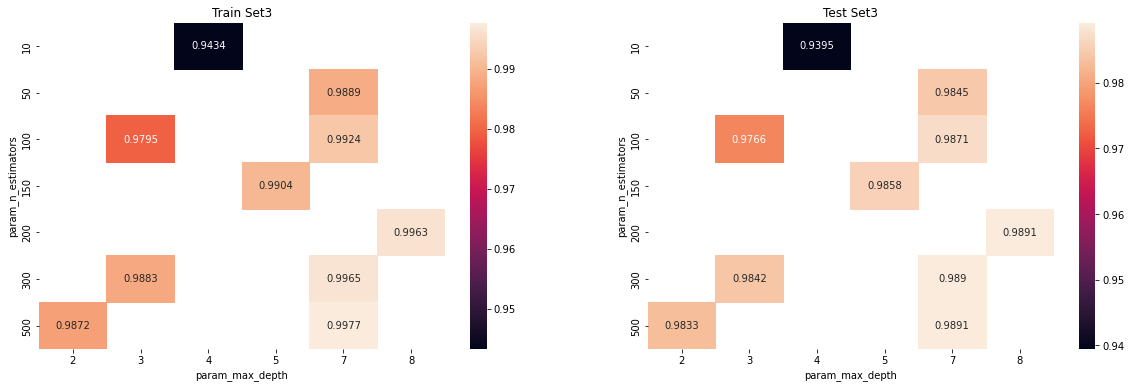

In [ ]:
max_scores34 = pd.DataFrame(Xgb_clf3.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores34.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores34.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set3')
ax[1].set_title('Test Set3')

plt.show()

{'n_estimators': 200, 'max_depth': 8}
-------------------------------------------------- Confusion matrix --------------------------------------------------


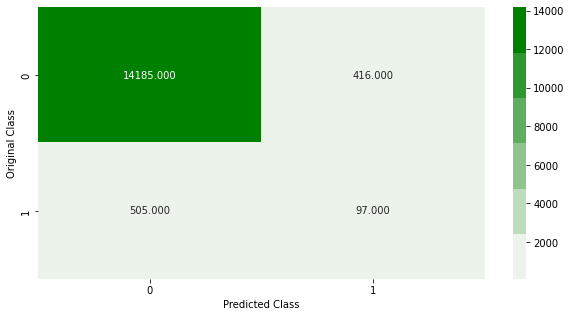

-------------------------------------------------- Precision matrix --------------------------------------------------


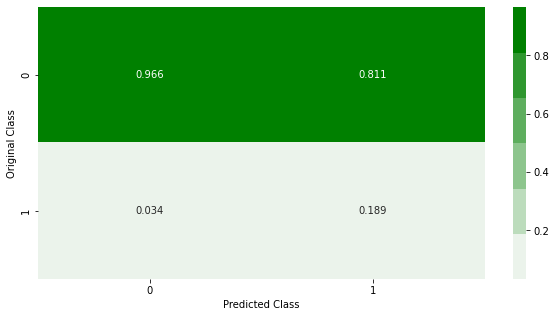

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


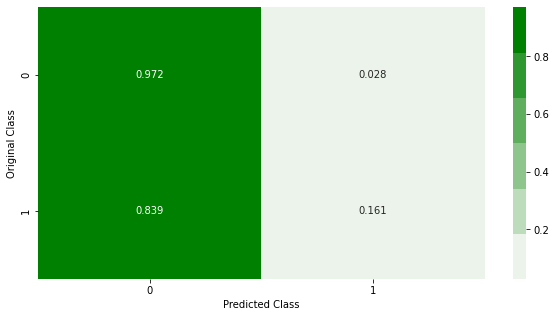

Sum of rows in precision matrix [1. 1.]
train_auc:  0.9962097127643476
test_auc:  0.8237824355998007


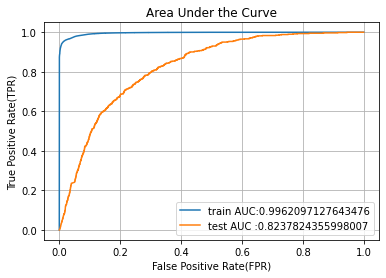

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
Xgb_be3=Xgb_clf3.best_params_ # store the best parameters of the model
print(Xgb_be3)
# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_Xgb3 = XGBClassifier(max_depth=Xgb_be3["max_depth"],n_estimators=Xgb_be3["n_estimators"],scale_pos_weight=w)


# train the best parameters model using train set
best_model_Xgb3.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_Xgb3.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_Xgb3.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_Xgb3.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc34 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc34)

test_auc34 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc34)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(Xgb_clf3, open('Xgb_clf3.pkl', 'wb'))
best_model = pickle.load(open('Xgb_clf3.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("Xgb_Classifier_ADASYN.csv", index=False)

shape of the test dataset: (75818, 370)


## RF

In [ ]:
from sklearn.metrics import roc_curve , confusion_matrix
import sklearn

# GBDT ASSAIGNMENT-11
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier

gbdt = RandomForestClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500], 'max_depth':[2, 3, 4, 5, 6, 7, 8]}
 
RF_clf3 = RandomizedSearchCV(gbdt,grid_params ,cv=3,return_train_score=True, scoring='roc_auc',n_jobs=-1)
RF_clf3.fit(X_train, y_train)

print("cassification best parameters : ",RF_clf3.best_params_)

print('Best score: ',RF_clf3.best_score_)
print('k value with best score: ',RF_clf3.best_params_)
print('='*50)
print('Train AUC scores')
print(RF_clf3.cv_results_['mean_train_score'])
print('CV AUC scores')
print(RF_clf3.cv_results_['mean_test_score'])

cassification best parameters :  {'n_estimators': 300, 'max_depth': 8}
Best score:  0.9520539812450503
k value with best score:  {'n_estimators': 300, 'max_depth': 8}
Train AUC scores
[0.93751951 0.89768291 0.94518369 0.94853397 0.8751993  0.95761289
 0.93334978 0.92428078 0.89853038 0.91108598]
CV AUC scores
[0.93314044 0.89532111 0.94004812 0.94377011 0.87347504 0.95205398
 0.93073686 0.92122332 0.89597106 0.90798077]


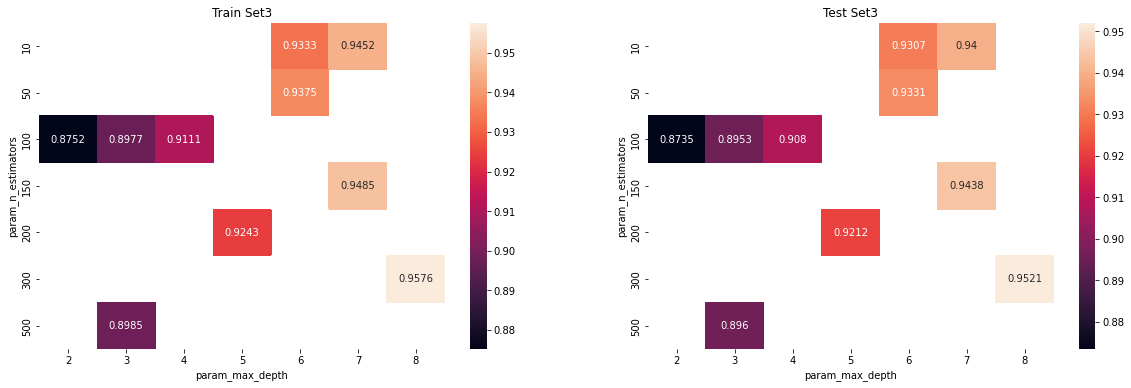

In [ ]:
max_scores35 = pd.DataFrame(RF_clf3.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
# by unstack getting mean train score and mean test score.
fig, ax = plt.subplots(1,2, figsize=(20,6))
# take train score
sns.heatmap(max_scores35.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
# take cv score
sns.heatmap(max_scores35.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set3')
ax[1].set_title('Test Set3')

plt.show()

{'n_estimators': 300, 'max_depth': 8}
-------------------------------------------------- Confusion matrix --------------------------------------------------


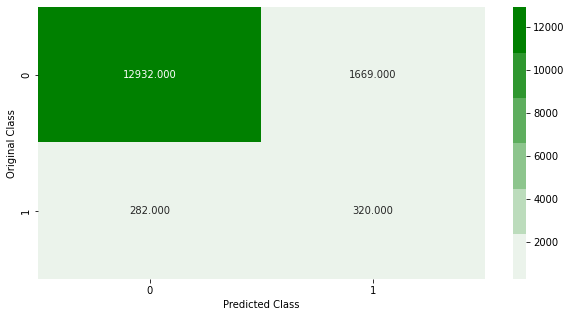

-------------------------------------------------- Precision matrix --------------------------------------------------


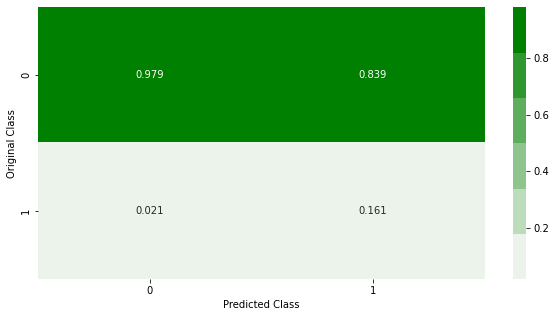

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


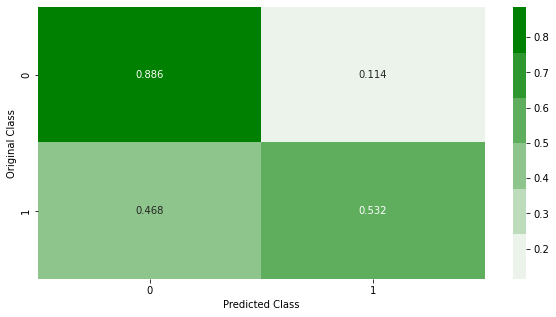

Sum of rows in precision matrix [1. 1.]
train_auc:  0.9564235738656013
test_auc:  0.8052795159663437


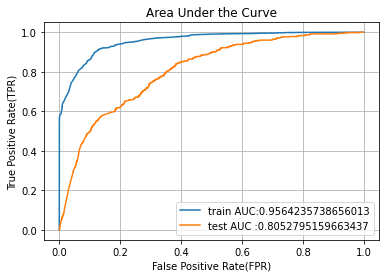

In [ ]:
from sklearn.metrics import roc_curve , auc
import collections
from collections import Counter
RF_be3=RF_clf3.best_params_ # store the best parameters of the model
print(RF_be3)
# initialize the best model
a=Counter(y_train)
#w=a[1]/(a[0]+a[1])
w=a[0]/a[1]
#w= np.sqrt(a[0]/a[1])

best_model_RF3 = RandomForestClassifier(max_depth=RF_be3["max_depth"],n_estimators=RF_be3["n_estimators"])


# train the best parameters model using train set
best_model_RF3.fit(X_train,y_train)

# find the predicted labels of the train data
y_train_pred1 = best_model_RF3.predict_proba(X_train)[:,1]
# find the predicted labels for the test data
y_test_pred1 = best_model_RF3.predict_proba(X_test)[:,1]
y_test_predict1 = best_model_RF3.predict(X_test)
plot_confusion_matrix(y_test , y_test_predict1)

# got the tpr,fpr and thresholds from the roc-curve metric
train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(y_test,y_test_pred1)

# auc takes fpr , tpr gives the auc value
train_auc35 = auc(train_fpr1,train_tpr1)
print("train_auc: ",train_auc35)

test_auc35 = auc(test_fpr1,test_tpr1)
print("test_auc: ",test_auc35)

plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

plt.title("Area Under the Curve")
plt.grid()
plt.show()

In [ ]:
import pickle
# dump the classification model.
pickle.dump(RF_clf3, open('RF_clf3.pkl', 'wb'))
best_model = pickle.load(open('RF_clf3.pkl', 'rb'))
#best_model.predict(X_test)
#
df_test = pd.read_csv("test.csv")
print("shape of the test dataset:",df_test.shape)
test_feat = df_test.drop(["ID"],axis=1)
test_feats = test_feat[X_train.columns]
test_predicted_vals = best_model.predict_proba(test_feats)[:,1] # we need probability scores.

#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": test_predicted_vals})


submit_base.to_csv("RF_Classifier_ADASYN.csv", index=False)

shape of the test dataset: (75818, 370)


## summary

In [ ]:
from prettytable import PrettyTable
TB3 = PrettyTable()
TB3.title = "ADASYN"
TB3.field_names = ["Model","Train_AUC","Test_AUC"]
M1 = "logistic regression"
M2 = "Decision tree"
M3 = "support vector machine"
M4 = "Xgboost classifier"
M5 = "Random Forest Classifier"
# parameters 
a31 = lg_be3
a32 = DT_be3
#a33 = SVM_be3
a34 = Xgb_be3
a35 = RF_be3
# train auc values
tr31 = train_auc31
tr32 = train_auc32
#tr33 = train_auc33
tr34 = train_auc34
tr35 = train_auc35
# test auc values
te31 = test_auc31
te32 = test_auc32
#te33 = test_auc33
te34 = test_auc34
te35 = test_auc35
# create table
TB3.add_row([M1, tr31, te31]) # a1["max_depth"] ,a1["n_estimators"],
TB3.add_row([M2, tr32, te32])
#TB3.add_row([M3, tr33, te33])
TB3.add_row([M4, tr34, te34])
TB3.add_row([M3, tr35, te35])
print(TB3)

+------------------------------------------------------------------+
|                              ADASYN                              |
+------------------------+--------------------+--------------------+
|         Model          |     Train_AUC      |      Test_AUC      |
+------------------------+--------------------+--------------------+
|  logistic regression   | 0.6274226712150186 | 0.6178235300408359 |
|     Decision tree      | 0.9920200102479346 | 0.7467399151880781 |
|   Xgboost classifier   | 0.9962097127643476 | 0.8237824355998007 |
| support vector machine | 0.9564235738656013 | 0.8052795159663437 |
+------------------------+--------------------+--------------------+


## summary table

In [ ]:
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
TB = PrettyTable()
TB.title = "Xgboost" # title of the table

# mention the required column names
TB.field_names = ["Model", "max_depth","n_estimators", "Train_AUC", "Test_Auc"]
# models
M1 = "base_model_dataset"
M2 = "constant_removal_base"
M3 = "quasiconstant_removal_base"
M4 = "base_smote_dataset"
M5 = "base_smotenc_dataset"
M6 = "base_adasyn_dataset"
M7 = "preprocessed_adasyn_dataset"
M8 = "preprocessed_adasyn_RFFI_0.001"
M9 = "preprocessed_adasyn_RFFI_0"
# parameters of the models
#a1 = clf1.best_params_
a1 =be1
#a2 = clf2.best_params_
a2 = be2
a3 = be3
a4 = be4
a5 = be5
a6 = be6
a7 = be7
a8 = be8
a9 = be9
# training auc values
tr1 =train_auc1
tr2 = train_auc2
tr3 = train_auc3
tr4 = train_auc4
tr5 = train_auc5
tr6 = train_auc6
tr7 = train_auc7
tr8 = train_auc8
tr9 = train_auc9
# testing auc values
te1 = test_auc1
te2 = test_auc2
te3 = test_auc3
te4 = test_auc4
te5 = test_auc5
te6 = test_auc6
te7 = test_auc7
te8 = test_auc8
te9 = test_auc9
# create table
TB.add_row([M1, a1["max_depth"] ,a1["n_estimators"], tr1, te1])
TB.add_row([M2, a2["max_depth"] ,a2["n_estimators"], tr2, te2])
TB.add_row([M3, a3["max_depth"] ,a3["n_estimators"], tr3, te3])
TB.add_row([M4, a4["max_depth"] ,a4["n_estimators"], tr4, te4])
TB.add_row([M5, a5["max_depth"] ,a5["n_estimators"], tr5, te5])
TB.add_row([M6, a6["max_depth"] ,a6["n_estimators"], tr6, te6])
TB.add_row([M7, a7["max_depth"] ,a7["n_estimators"], tr7, te7])
TB.add_row([M8, a8["max_depth"] ,a8["n_estimators"], tr8, te8])
TB.add_row([M9, a9["max_depth"] ,a9["n_estimators"], tr9, te9])

print(TB) # print the table


# FI

## RF

In [ ]:
model=RandomForestClassifier()
 
model.fit(X,Y)
# create dataframe with the features and its corresponding feature importance values. 
feature_importances=pd.DataFrame({'features':X.columns,'feature_importance':model.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False,inplace=True)

In [ ]:
feature_importances.head(3)

,features,feature_importance
263,var38,0.379598
1,var15,0.173843
228,saldo_medio_var5_ult3,0.028358


In [ ]:
top_features=feature_importances[feature_importances["feature_importance"]>0.01]
# I taken this threshold value based on the plot 
print(" top features data shape :",top_features.shape)
required=[] # creates an empty list to store column names
for i in top_features["features"][:]:
  required.append(i) # append those feature into required list
print("the no of features are selected : ",len(required))
# create new dataframe 

new_X = X[required] #select those required columns from the X dataframe
print("the shape of the new dataframe : ",new_X.shape)
new_X.to_csv("top_features.csv", index=False)
new_X.head(3)

 top features data shape : (17, 2)
the no of features are selected :  17
the shape of the new dataframe :  (76013, 17)


,var38,var15,saldo_medio_var5_ult3,saldo_medio_var5_hace3,num_var45_ult3,saldo_medio_var5_hace2,saldo_var30,num_var45_hace3,saldo_var42,num_var22_ult3,num_var45_hace2,saldo_medio_var5_ult1,saldo_var5,num_var45_ult1,num_var22_hace3,num_med_var45_ult3,num_var22_hace2
0,39205.17,23,0.00,0.00,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0
1,49278.03,34,0.00,88.89,0,0.0,300.0,0,0.0,0,0,0.0,0.0,0,0,0,0
2,67333.77,23,2.07,0.18,0,3.0,3.0,0,3.0,0,0,3.0,3.0,0,0,0,0


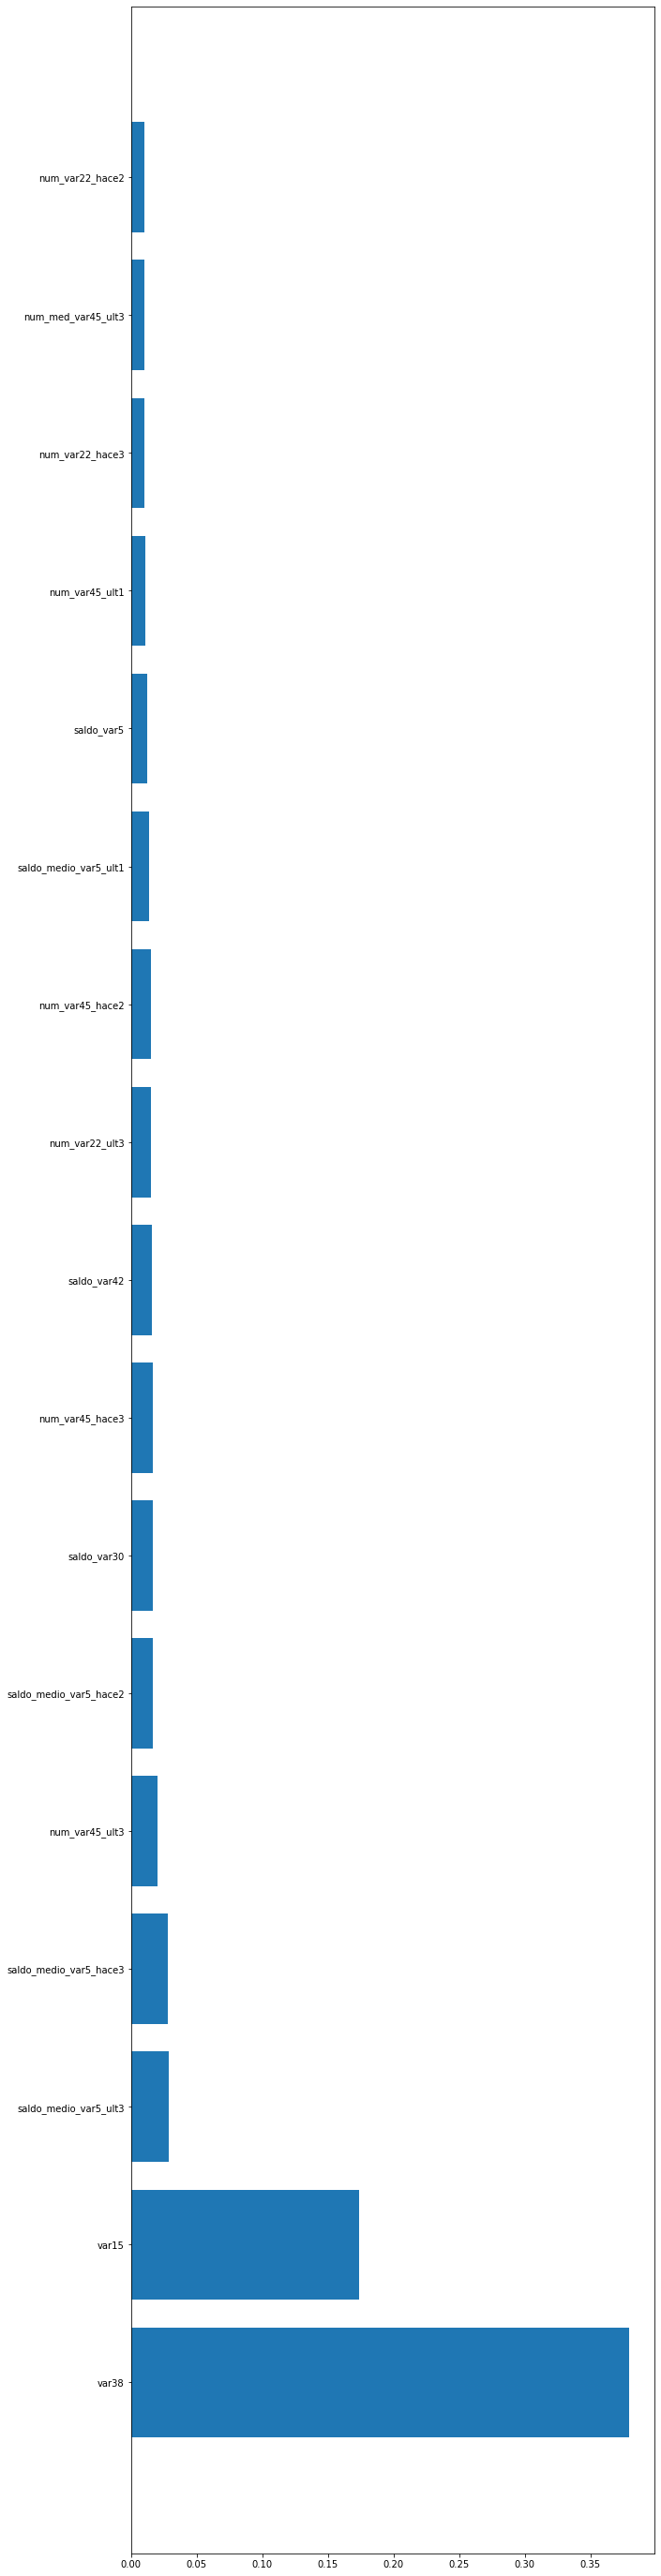

In [ ]:
plt.figure(figsize=(10,50))
plt.barh(top_features["features"], top_features["feature_importance"])
plt.show()


In [ ]:
# feature importance is 0.001 then auc is 0.800
# feature importance is 0.0001 then auc is 0.79
# feature importance is 0.01

In [ ]:
top_features.head()

,features,feature_importance
263,var38,0.379598
1,var15,0.173843
228,saldo_medio_var5_ult3,0.028358
226,saldo_medio_var5_hace3,0.028188
224,num_var45_ult3,0.020327


In [ ]:
top_features[top_features["features"]=="num_var30_0"]

,features,feature_importance


In [ ]:
from imblearn.over_sampling import ADASYN
from collections import Counter
counter = Counter(y_train)
print("before sampling : ",counter)
# transform the dataset
oversample = ADASYN()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)
print("after sampling",counter)

before sampling :  Counter({0: 46723, 1: 1925})
after sampling Counter({0: 46723, 1: 46385})
